In [2]:
import os


os.chdir('/Users/alex/ZSCIR/')

print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/alex/ZSCIR

In [3]:
import json
from typing import List

import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm
from rich import print
import matplotlib.pyplot as plt
from clip import tokenize
from transformers import CLIPVisionModelWithProjection, CLIPTextModelWithProjection, CLIPImageProcessor

from src.fashioniq_experiment.utils import element_wise_sum_original, get_combing_function_with_alpha, \
    convert_to_pivot_fiq, prepare_and_plot_recall_pivot, prepare_ground_truths, plot_retrieval_results_of_i, \
    found_better_than_original
from src.fashioniq_experiment.validate_notebook import fiq_val_retrieval_text_image_grid_search_clip, \
    compute_results_fiq_val_clip
from src.utils import device

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 1: Set up the experiment</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Set up the cache for the experiment</div>

In [4]:
cache = {}

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Same concept as script version here</div>

In [5]:
CLIP_NAME = 'laion/CLIP-ViT-H-14-laion2B-s32B-b79K'

In [9]:
clip_text_encoder = CLIPTextModelWithProjection.from_pretrained(CLIP_NAME, torch_dtype=torch.float32, projection_dim=1024)
clip_text_encoder = clip_text_encoder.float().to(device)

print("clip text encoder loaded.")
clip_text_encoder.eval()

'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /laion/CLIP-ViT-H-14-laion2B-s32B-b79K/resolve/main/config.json (Caused by ConnectTimeoutError(<HTTPSConnection(host='huggingface.co', port=443) at 0x326f4acb0>, 'Connection to huggingface.co timed out. (connect timeout=10)'))"), '(Request ID: 848e2388-0032-4d24-951d-0d1929025215)')' thrown while requesting HEAD https://huggingface.co/laion/CLIP-ViT-H-14-laion2B-s32B-b79K/resolve/main/config.json
Retrying in 1s [Retry 1/5].
Retrying in 1s [Retry 1/5].


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

Cancellation requested; stopping current tasks.


KeyboardInterrupt: 

In [6]:
clip_img_encoder = CLIPVisionModelWithProjection.from_pretrained(CLIP_NAME,torch_dtype=torch.float32, projection_dim=1024)

clip_img_encoder = clip_img_encoder.float().to(device)
print("clip img encoder loaded.")
clip_img_encoder.eval()

clip img encoder loaded.

CLIPVisionModelWithProjection(
  (vision_model): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (position_embedding): Embedding(257, 1280)
    )
    (pre_layrnorm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-31): 32 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (layer_norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1280, out_features=51

In [7]:
print('CLIP preprocess pipeline is used')
preprocess = CLIPImageProcessor(
    crop_size={'height': 224, 'width': 224},
    do_center_crop=True,
    do_convert_rgb=True,
    do_normalize=True,
    do_rescale=True,
    do_resize=True,
    image_mean=[0.48145466, 0.4578275, 0.40821073],
    image_std=[0.26862954, 0.26130258, 0.27577711],
    resample=3,
    size={'shortest_edge': 224},
)

CLIP preprocess pipeline is used

In [8]:
clip_tokenizer = tokenize

In [9]:
combining_function_original = element_wise_sum_original

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 2: Load the MLLM generated text captions</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the addition text captions</div>

In [11]:
with open('../../../fashionIQ_dataset/labeled_images_cir_cleaned.json', 'r') as f:
    text_captions = json.load(f)
    
total_recall_list: List[List[pd.DataFrame]] = []

print(f'Total number of text captions: {len(text_captions)}')

Total number of text captions: 74357

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 3: Perform retrieval on the FashionIQ dataset</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the shirt category</div>

In [12]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
shirt_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    shirt_recall = fiq_val_retrieval_text_image_grid_search_clip(
        'shirt',
        get_combing_function_with_alpha(alpha),
        clip_text_encoder,
        clip_img_encoder,
        clip_tokenizer,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    shirt_recall_list.append(shirt_recall)

shirt_recall_at10, shirt_recall_at50 = convert_to_pivot_fiq(shirt_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [13]:
display(shirt_recall_at10, shirt_recall_at50)

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   14.131501  14.573111  14.916585  15.358195  16.045143  16.683023   
0.05   14.033367  14.376840  14.965652  15.456329  16.339548  16.830225   
0.10   13.935231  14.425908  14.622179  15.358195  16.290481  17.075564   
0.15   13.542689  13.984299  14.376840  14.916585  15.799804  16.879293   
0.20   13.297351  13.935231  14.425908  15.063788  15.652600  16.633955   
0.25   12.953876  13.493621  14.082433  14.622179  15.456329  16.535820   
0.30   12.463199  13.002944  13.542689  14.180569  14.818449  15.947007   
0.35   11.972522  12.512267  13.101080  13.640824  14.425908  15.309127   
0.40   11.874387  12.217861  12.904808  13.395485  13.984299  14.867517   
0.45   11.187439  11.776251  12.168793  12.953876  13.689892  14.327772   
0.50   10.402355  10.942100  11.678116  12.414131  12.953876  13.689892   
0.55    9.764475  10.058881  10.647694  11.874387  12.561335  13.248283   
0.60    9.028459   9.322865   9.960746  10.843965  12.070657  13.002944   
0.65    8.488715   8.783121   9.273798   9.960746  11.040235  12.119725   
0.70    7.899902   8.096173   8.832189   9.421001  10.107949  11.285574   
0.75    7.163886   7.556428   7.948969   8.881256   9.519137  10.304220   
0.80    6.967615   7.262021   7.605495   8.341511   8.979391   9.519137   
0.85    6.771345   7.016683   7.409225   7.850834   8.439647   9.175663   
0.90    6.476938   6.624141   7.114819   7.507360   8.096173   8.734053   
0.95    5.937193   6.378803   6.624141   7.065751   7.605495   8.341511   
1.00    5.691855   6.084396   6.182532   6.427871   7.114819   7.654563   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   17.419039  18.351325  19.578017  21.540727  ...  25.809616  28.213936   
0.05   17.713444  18.498528  19.528949  21.589793  ...  26.545632  28.900883   
0.10   17.860648  18.645731  19.872424  21.786065  ...  26.889107  29.685965   
0.15   17.615309  18.547596  20.019627  21.835132  ...  26.938176  30.127576   
0.20   17.664377  19.136408  20.264965  22.325809  ...  27.526987  30.520117   
0.25   17.615309  19.185476  20.755643  22.669284  ...  27.625123  29.833171   
0.30   16.977429  18.645731  20.166831  22.423945  ...  27.036309  29.342493   
0.35   16.732091  18.400392  20.019627  22.276741  ...  27.085379  28.999019   
0.40   15.947007  17.517173  19.185476  21.589793  ...  26.594701  28.753680   
0.45   15.407263  17.026496  18.694799  20.902845  ...  25.858685  28.164867   
0.50   14.622179  15.996075  18.105987  20.510304  ...  25.417075  27.085379   
0.55   14.131501  15.505397  17.762512  19.627085  ...  24.239451  26.398429   
0.60   13.689892  14.965652  16.732091  18.989205  ...  23.454367  25.269872   
0.65   12.904808  14.131501  16.094211  18.056919  ...  22.276741  24.337585   
0.70   12.463199  13.297351  15.210991  17.075564  ...  21.197252  23.209028   
0.75   11.432777  12.414131  14.376840  16.339548  ...  20.510304  21.835132   
0.80   10.598626  11.530913  13.689892  15.701668  ...  19.479883  20.902845   
0.85   10.058881  11.187439  13.199215  14.573111  ...  18.449460  20.215897   
0.90    9.371933  10.549559  12.266929  14.033367  ...  17.615309  18.940137   
0.95    8.930324  10.107949  11.727183  13.493621  ...  16.683023  18.155053   
1.00    8.586850   9.519137  11.138371  12.610403  ...  15.210991  16.977429   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   30.814525  33.611384  34.838077  35.426888  34.151128  30.569187   
0.05   31.746811  34.200197  35.623160  35.868499  34.543669  30.912659   
0.10   32.335624  34.396467  36.506379  36.555445  34.641805  31.207067   
0.15   32.384691  34.739941  36.408243  35.966635  34.4455

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   26.643768  27.576056  28.361139  28.999019  29.784101  30.863592   
0.05   27.134445  27.821395  28.753680  29.636899  30.323848  31.207067   
0.10   27.232581  27.968597  28.655544  29.587832  30.323848  31.550539   
0.15   26.643768  27.625123  28.312069  29.195291  30.225712  31.648675   
0.20   26.153091  27.330717  27.919528  28.900883  29.784101  31.157997   
0.25   25.662413  26.692837  27.428851  28.606477  29.784101  30.961728   
0.30   24.975467  25.956821  26.889107  27.919528  29.342493  30.520117   
0.35   24.484789  25.515211  26.447499  27.576056  28.999019  30.372915   
0.40   23.356232  24.730128  26.104024  27.036309  28.263003  29.980373   
0.45   22.620216  23.748773  25.024533  26.545632  27.870461  29.489696   
0.50   21.393523  22.571148  24.141315  25.564280  26.889107  28.361139   
0.55   20.755643  21.393523  23.012757  24.190383  25.613347  27.183512   
0.60   19.676153  20.264965  21.491659  22.669284  24.190383  25.907752   
0.65   18.596664  19.332679  20.166831  21.491659  22.522080  24.435721   
0.70   17.958783  18.449460  19.234544  20.510304  21.540727  23.159961   
0.75   17.124632  17.566241  18.351325  19.234544  20.363101  22.080471   
0.80   16.143277  16.584887  17.222768  18.253189  19.479883  21.000981   
0.85   14.769381  15.358195  16.143277  17.124632  18.351325  19.725221   
0.90   14.082433  14.769381  15.358195  16.045143  17.320903  18.547596   
0.95   13.297351  13.935231  14.867517  15.309127  16.241413  17.517173   
1.00   12.659471  13.052012  13.886163  14.376840  15.456329  16.830225   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   32.041216  33.660451  35.623160  36.947989  ...  42.885181  45.240432   
0.05   32.875368  34.249264  36.064771  37.880275  ...  43.081453  45.731109   
0.10   32.875368  34.494603  36.800784  38.910696  ...  43.866536  46.221787   
0.15   32.973504  34.789008  36.947989  39.106968  ...  44.504416  46.908733   
0.20   33.169773  34.789008  36.751717  39.548576  ...  44.700688  47.006869   
0.25   33.022571  34.739941  36.800784  39.401373  ...  44.504416  47.350344   
0.30   32.433757  34.445536  36.653581  39.156035  ...  44.896957  47.252208   
0.35   32.041216  34.003925  36.653581  38.910696  ...  44.602552  46.908733   
0.40   31.697744  33.562315  36.162904  38.763493  ...  43.817469  46.516192   
0.45   30.863592  32.973504  35.672227  38.272816  ...  43.130520  45.829245   
0.50   29.784101  32.188421  34.690875  37.389597  ...  42.394504  44.602552   
0.55   28.704613  31.207067  33.169773  35.574093  ...  41.364083  43.473995   
0.60   27.428851  30.127576  32.090285  34.789008  ...  40.186456  41.756624   
0.65   26.300293  29.097155  31.305200  33.660451  ...  38.518155  40.382728   
0.70   25.368008  28.017664  29.833171  32.531893  ...  37.242395  39.450443   
0.75   24.141315  26.300293  28.263003  30.912659  ...  36.261040  38.174680   
0.80   22.718351  24.631992  26.938176  29.244357  ...  35.034347  37.242395   
0.85   21.246320  23.699705  25.171736  27.723259  ...  33.758587  35.132483   
0.90   20.608440  22.276741  24.435721  26.643768  ...  31.894013  33.415112   
0.95   19.332679  21.344456  23.258096  25.564280  ...  30.323848  31.697744   
1.00   18.204121  20.215897  22.227675  24.337585  ...  28.704613  29.882237   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   47.203141  50.196272  51.913643  52.355248  50.736016  47.742885   
0.05   48.380765  50.883222  52.649659  53.238469  51.472032  47.939157   
0.10   48.626104  51.373893  52.796859  53.581941  51.226693  48.282629   
0.15   49.411187  51.619232  52.944064  53.140336  51.3738

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the dress category</div>

In [14]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
dress_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    dress_recall = fiq_val_retrieval_text_image_grid_search_clip(
        'dress',
        get_combing_function_with_alpha(alpha),
        clip_text_encoder,
        clip_img_encoder,
        clip_tokenizer,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    dress_recall_list.append(dress_recall)

dress_recall_at10, dress_recall_at50 = convert_to_pivot_fiq(dress_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [15]:
display(dress_recall_at10, dress_recall_at50)

alpha      0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
beta                                                                          
0.00   5.651958  6.098166  6.395637  6.841844  7.238473  7.783838  8.626673   
0.05   5.800694  6.098166  6.296480  6.693108  7.089737  7.684680  8.775409   
0.10   5.751115  6.197323  6.445216  6.941001  7.436787  7.833416  9.072880   
0.15   5.701537  5.999009  6.246901  6.792266  7.337630  7.833416  8.577095   
0.20   5.552801  5.701537  5.850273  6.296480  6.841844  7.684680  8.378781   
0.25   5.651958  5.751115  6.048587  6.346059  6.693108  7.486366  8.180466   
0.30   5.304908  5.453644  5.751115  5.999009  6.693108  7.238473  7.882994   
0.35   4.858701  5.057015  5.404066  5.899851  6.246901  6.841844  7.486366   
0.40   4.660387  4.809123  5.255330  5.552801  5.800694  6.494794  7.188895   
0.45   4.313337  4.610808  4.858701  5.304908  5.503223  5.949430  6.346059   
0.50   4.015865  4.362915  4.561229  4.858701  5.156172  5.651958  6.147744   
0.55   3.718394  3.916708  4.164601  4.412494  4.660387  4.957858  5.552801   
0.60   3.371344  3.767972  3.916708  4.015865  4.263758  4.709965  5.205751   
0.65   3.222608  3.520079  3.619236  3.718394  4.065444  4.362915  4.957858   
0.70   2.974715  3.173029  3.371344  3.420922  3.668815  4.065444  4.412494   
0.75   2.429350  2.776401  2.875558  3.123451  3.173029  3.520079  3.767972   
0.80   2.379772  2.429350  2.677243  2.677243  3.024293  3.272187  3.569658   
0.85   2.330193  2.379772  2.528508  2.726822  2.776401  3.024293  3.321765   
0.90   2.131879  2.231036  2.478929  2.578086  2.776401  2.875558  3.173029   
0.95   2.131879  2.231036  2.429350  2.478929  2.627665  2.776401  3.123451   
1.00   1.735250  1.883986  1.983143  2.181458  2.429350  2.578086  2.925136   

alpha      0.35       0.40       0.45  ...       0.55       0.60       0.65  \
beta                                   ...                                    
0.00   9.221616  10.609817  12.295488  ...  17.203768  19.781855  22.954884   
0.05   9.519088  10.907288  12.989588  ...  17.600396  20.723847  23.797719   
0.10   9.618245  10.857709  12.890431  ...  17.699553  20.823005  23.301934   
0.15   9.419931  10.956866  12.592959  ...  17.352504  20.128904  23.450670   
0.20   9.370352  10.659395  12.196331  ...  17.302924  19.781855  23.202777   
0.25   9.419931  10.708974  12.097174  ...  16.460089  19.533962  21.963312   
0.30   9.172038  10.510659  11.750124  ...  16.063461  18.839861  21.170054   
0.35   8.626673  10.163610  11.403074  ...  15.171047  17.600396  19.434804   
0.40   8.031730   9.469509  10.609817  ...  14.427367  16.460089  18.641546   
0.45   7.486366   8.874566   9.866138  ...  13.832425  15.270203  17.501239   
0.50   6.941001   8.329201   9.172038  ...  12.890431  14.576103  15.964304   
0.55   6.544373   7.486366   8.378781  ...  11.750124  13.534953  14.972731   
0.60   5.999009   6.990580   7.982152  ...  10.560238  12.245910  13.832425   
0.65   5.453644   6.445216   7.486366  ...  10.163610  11.700545  12.543382   
0.70   5.156172   5.949430   6.643530  ...   9.568667  10.609817  11.650967   
0.75   4.412494   5.453644   6.296480  ...   8.676252  10.014874  10.659395   
0.80   3.966286   4.709965   5.651958  ...   7.982152   9.469509   9.717402   
0.85   3.817551   4.511651   5.106594  ...   7.436787   8.626673   8.924145   
0.90   3.718394   4.065444   4.759544  ...   6.494794   7.833416   8.031730   
0.95   3.272187   3.867129   4.511651  ...   5.552801   6.792266   7.387209   
1.00   3.024293   3.668815   3.767972  ...   5.304908   5.999009   6.593952   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00   25.830442  28.458107  28.755578  28.606841  25.433812  21.517104   
0.05   25.780863  28.656420  29.152206  28.210214  25.880021  22.359940   
0.10   26.227069  27.714428  28.755578  27.565691  25.483391  21

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   16.757561  17.253347  17.947447  19.038175  19.881012  21.219634   
0.05   16.757561  17.550819  17.897868  18.939018  19.930591  21.120475   
0.10   16.807139  17.501239  18.195340  19.186911  20.079325  21.269211   
0.15   16.559246  16.955875  18.145761  19.038175  20.079325  21.219634   
0.20   16.013882  16.707982  17.501239  18.691126  19.732276  21.170054   
0.25   15.270203  15.914725  16.807139  17.848289  19.286068  20.327219   
0.30   13.931581  14.427367  15.617253  16.460089  17.897868  19.385226   
0.35   13.187903  13.584532  14.576103  15.121467  16.460089  17.749132   
0.40   12.245910  12.890431  13.782845  14.377789  15.468517  16.658403   
0.45   11.403074  12.047596  12.940010  13.534953  14.724839  15.716411   
0.50   10.956866  11.452653  11.948438  12.791274  13.584532  14.625682   
0.55   10.312345  10.758552  11.105602  11.898860  12.592959  13.485375   
0.60    9.667823   9.816559  10.213188  11.155181  11.998017  12.791274   
0.65    8.973724   9.271195   9.717402  10.262766  10.907288  11.700545   
0.70    8.428359   9.072880   9.221616   9.667823  10.163610  10.510659   
0.75    8.031730   8.329201   9.023302   9.221616   9.816559  10.262766   
0.80    7.486366   7.684680   8.130887   8.775409   9.122459   9.667823   
0.85    6.693108   7.040159   7.486366   7.932573   8.577095   9.072880   
0.90    6.147744   6.544373   6.841844   7.288051   7.585523   8.676252   
0.95    5.899851   6.246901   6.445216   6.593952   7.188895   8.031730   
1.00    5.503223   5.850273   6.048587   6.098166   6.445216   7.139315   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   22.855726  24.690133  26.673278  29.350519  ...  34.457114  38.274667   
0.05   22.855726  24.987605  27.268219  29.647991  ...  35.696578  39.365393   
0.10   22.806148  24.938026  26.871592  29.548836  ...  36.241943  39.315817   
0.15   22.459097  24.442241  26.574120  29.400098  ...  36.390680  39.514130   
0.20   22.260784  24.045612  26.425385  29.053050  ...  35.696578  39.266238   
0.25   21.764998  23.500247  25.880021  29.003471  ...  35.151213  38.225088   
0.30   20.922162  22.954884  24.789292  27.962321  ...  34.506693  36.836886   
0.35   19.533962  21.368369  23.946455  26.722854  ...  32.821020  35.448685   
0.40   18.344076  19.781855  22.855726  25.632128  ...  31.879029  34.159642   
0.45   17.154190  18.988597  21.665840  24.095191  ...  29.697570  32.622707   
0.50   16.063461  17.550819  20.475954  23.103619  ...  27.912742  31.085771   
0.55   14.873575  16.509669  18.939018  21.665840  ...  26.772434  29.449677   
0.60   14.080317  15.468517  17.749132  20.128904  ...  25.433812  27.664849   
0.65   13.039167  14.675260  16.311353  18.344076  ...  23.648983  26.127914   
0.70   11.700545  13.138324  15.022311  17.005454  ...  21.814576  24.194348   
0.75   10.956866  12.047596  13.981161  15.765989  ...  20.624690  22.211204   
0.80   10.758552  11.403074  12.840852  14.972731  ...  18.691126  20.922162   
0.85   10.064452  10.708974  12.097174  14.030738  ...  17.550819  19.038175   
0.90    9.320773   9.965295  11.353495  12.592959  ...  16.013882  17.600396   
0.95    8.626673   9.271195  10.312345  11.650967  ...  15.071888  16.509669   
1.00    7.833416   8.725830   9.618245  10.808131  ...  14.179474  15.418939   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   42.092216  45.413980  47.645018  48.636588  48.487854  45.215666   
0.05   42.637581  45.959345  47.694597  48.934060  48.388696  45.810610   
0.10   43.034208  45.810610  48.239961  48.983639  48.041645  45.413980   
0.15   43.034208  45.463559  47.892910  48.091224  47.0500

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the toptee category</div>

In [16]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
toptee_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    toptee_recall = fiq_val_retrieval_text_image_grid_search_clip(
        'toptee',
        get_combing_function_with_alpha(alpha),
        clip_text_encoder,
        clip_img_encoder,
        clip_tokenizer,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    toptee_recall_list.append(toptee_recall)
    
toptee_recall_at10, toptee_recall_at50 = convert_to_pivot_fiq(toptee_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [17]:
display(toptee_recall_at10, toptee_recall_at50)

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   10.096889  10.504845  10.963794  11.626721  12.136665  12.901580   
0.05    9.841917  10.555839  11.116777  11.320755  12.034676  12.952575   
0.10    9.892911  10.453850  10.963794  11.575726  12.340643  13.309535   
0.15    9.637940  10.249873  10.759816  11.626721  12.289649  13.156553   
0.20    9.229985   9.994900  10.555839  11.473738  12.085670  13.207547   
0.25    8.618052   9.382968  10.351861  11.218766  11.983681  12.952575   
0.30    8.669046   9.331974  10.096889  10.861805  11.575726  12.952575   
0.35    8.108108   8.669046   9.382968  10.147884  11.065783  12.544620   
0.40    7.649159   8.261091   8.873024   9.790923  10.453850  11.779704   
0.45    7.190209   7.802141   8.618052   9.127996   9.841917  11.371749   
0.50    6.578276   7.190209   7.649159   8.567058   9.280979  10.453850   
0.55    6.119327   6.170321   6.782254   7.496175   8.414075   9.688934   
0.60    5.609383   5.915349   6.527282   7.037226   8.210097   9.026007   
0.65    5.201428   5.762366   6.119327   6.935237   7.649159   8.567058   
0.70    4.895461   5.303417   5.966344   6.782254   7.394186   8.159102   
0.75    4.793473   5.099439   5.864355   6.272310   6.986231   7.802141   
0.80    4.742478   4.997450   5.456400   5.966344   6.578276   7.139215   
0.85    4.487506   4.640489   5.099439   5.609383   6.221316   6.680265   
0.90    3.926568   4.334523   4.895461   5.354411   5.762366   6.221316   
0.95    3.518613   3.875574   4.436512   5.099439   5.405406   5.966344   
1.00    3.263641   3.467619   4.028557   4.793473   4.997450   5.558389   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   13.972463  15.349312  16.522183  18.459970  ...  24.171340  27.078021   
0.05   14.329425  15.553290  17.032127  19.071902  ...  25.395206  28.301886   
0.10   14.431413  16.114227  17.848037  19.887812  ...  26.007140  29.321775   
0.15   14.533402  16.522183  18.052015  20.703723  ...  26.568079  29.678735   
0.20   14.533402  16.573177  18.357980  20.907700  ...  26.517084  30.137685   
0.25   14.227435  16.216215  18.154003  20.601735  ...  26.976034  30.086690   
0.30   14.533402  16.114227  18.052015  20.193778  ...  26.517084  29.525751   
0.35   13.972463  15.604283  17.593065  19.887812  ...  25.956145  28.709841   
0.40   13.054565  14.941357  17.083120  19.683835  ...  25.854155  28.250891   
0.45   12.646610  13.921468  16.675165  18.510965  ...  25.089240  27.740949   
0.50   11.932687  13.819480  16.165222  18.052015  ...  24.579297  26.619071   
0.55   10.810811  12.799592  15.094340  17.287098  ...  23.406425  25.752166   
0.60   10.300867  12.034676  14.176440  16.930138  ...  22.182560  24.528302   
0.65    9.688934  11.473738  13.717490  15.859255  ...  21.417645  23.406425   
0.70    9.280979  10.606834  12.850587  15.043345  ...  20.448750  22.641510   
0.75    8.822030  10.351861  11.932687  14.227435  ...  19.581845  21.009690   
0.80    8.363080  10.045895  11.575726  13.462520  ...  18.154003  19.938807   
0.85    7.904130   9.280979  10.708822  12.697603  ...  16.879143  18.357980   
0.90    7.292198   8.720041   9.943906  11.779704  ...  16.063233  17.950025   
0.95    6.782254   8.108108   9.280979  11.065783  ...  15.145335  16.879143   
1.00    6.374299   7.649159   9.077001  10.351861  ...  14.482407  15.808260   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   31.004590  34.115246  37.735850  38.398775  38.041815  35.186130   
0.05   31.769505  35.798061  37.990820  39.622641  38.551760  35.798061   
0.10   32.585415  36.206016  38.551760  39.724630  38.500765  35.951045   
0.15   32.840389  36.460990  38.653749  39.061704  38.0928

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   22.743498  23.304437  24.069352  25.344211  26.109129  27.536970   
0.05   22.284548  22.998470  24.018358  25.140235  26.262110  27.740949   
0.10   22.182560  23.049465  24.120347  24.987252  26.160121  28.046915   
0.15   21.978582  22.794493  23.814380  24.834268  26.364100  27.893931   
0.20   21.774605  22.182560  23.508415  24.732280  26.670066  27.587965   
0.25   21.111678  22.029577  23.457420  24.987252  26.211116  27.587965   
0.30   20.856705  21.978582  22.998470  24.528302  25.956145  27.129015   
0.35   20.448750  21.213667  22.335543  23.916370  25.293219  26.925039   
0.40   19.734830  20.397756  21.519633  22.947475  24.834268  26.058134   
0.45   18.255992  19.275880  20.346762  21.978582  23.712392  25.701174   
0.50   16.777155  18.204997  19.428863  20.499745  22.488527  24.375318   
0.55   16.165222  17.083120  18.103008  19.530852  21.264660  23.253442   
0.60   14.788373  16.165222  17.134115  18.765935  20.397756  21.876593   
0.65   14.278430  15.043345  16.369200  17.746048  19.173890  21.162672   
0.70   13.462520  14.380418  15.349312  16.675165  18.816930  19.989800   
0.75   13.156553  13.819480  14.584395  15.910250  17.542070  19.173890   
0.80   12.187659  13.003570  13.768485  14.941357  16.726160  18.154003   
0.85   11.575726  12.391637  13.156553  14.023457  15.706272  17.032127   
0.90   10.759816  11.728710  12.646610  13.411525  14.431413  16.318205   
0.95   10.453850  11.116777  11.881693  12.646610  13.258542  15.349312   
1.00   10.096889  10.810811  11.473738  12.085670  12.799592  14.329425   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   28.760836  30.698624  33.656299  36.308005  ...  43.447220  47.322795   
0.05   29.219785  31.463540  34.370220  37.123916  ...  44.365120  48.240694   
0.10   29.372770  31.667516  35.084140  38.245794  ...  45.486996  49.821520   
0.15   29.678735  31.871495  35.594085  38.653749  ...  45.690975  50.229472   
0.20   29.270780  32.177460  35.798061  39.010710  ...  46.047935  50.433451   
0.25   28.964815  31.922489  35.288119  38.551760  ...  46.353900  50.280470   
0.30   29.474759  31.820500  35.186130  38.143805  ...  46.149924  50.229472   
0.35   29.168791  31.769505  34.625190  38.143805  ...  45.639980  49.413565   
0.40   28.862825  31.616521  34.115246  37.735850  ...  45.130035  48.393676   
0.45   27.944925  30.698624  33.809280  37.072921  ...  44.008160  47.271800   
0.50   26.925039  29.423764  32.840389  35.849056  ...  43.090260  46.251911   
0.55   25.599185  28.199899  31.565529  34.829170  ...  41.560429  44.773075   
0.60   24.681285  26.823050  30.086690  33.605304  ...  40.795511  43.294239   
0.65   23.457420  26.058134  28.862825  32.483426  ...  39.367670  42.019379   
0.70   22.692505  24.936257  27.893931  30.953595  ...  38.092810  40.387556   
0.75   21.213667  24.069352  26.823050  30.137685  ...  36.511984  38.755736   
0.80   20.346762  22.743498  25.803161  29.066804  ...  35.084140  37.378889   
0.85   19.377868  21.468638  24.324325  27.332994  ...  33.758286  35.849056   
0.90   18.204997  20.448750  22.998470  26.262110  ...  32.177460  34.370220   
0.95   17.185110  19.479857  21.876593  25.140235  ...  30.443650  32.942376   
1.00   16.216215  18.154003  20.754717  23.712392  ...  28.811830  31.565529   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   51.453340  54.563999  57.419682  59.102499  58.643550  56.297809   
0.05   52.269250  55.277920  58.541560  59.306479  58.592552  56.144822   
0.10   52.779192  56.399798  58.643550  59.867412  58.796531  55.940849   
0.15   53.442121  56.348801  58.694541  59.051502  58.3885

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the average recall at 10 and 50 for all categories for alpha and beta</div>

In [18]:
average_recall_at10 = (shirt_recall_at10 + dress_recall_at10 + toptee_recall_at10) / 3
average_recall_at50 = (shirt_recall_at50 + dress_recall_at50 + toptee_recall_at50) / 3

In [19]:
print("Average Recall@10 for each alpha across all alphas:")
average_recall_at10

Average Recall@10 for each alpha across all alphas:

alpha      0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                     
0.00   9.960116  10.392040  10.758672  11.275587  11.806760  12.456147   
0.05   9.891993  10.343615  10.792970  11.156731  11.821320  12.489160   
0.10   9.859753  10.359027  10.677063  11.291641  12.022637  12.739505   
0.15   9.627389  10.077727  10.461186  11.111857  11.809027  12.623087   
0.20   9.360046   9.877223  10.277340  10.944668  11.526705  12.508727   
0.25   9.074629   9.542568  10.160961  10.729001  11.377706  12.324920   
0.30   8.812385   9.262854   9.796898  10.347128  11.029095  12.046018   
0.35   8.313110   8.746109   9.296038   9.896186  10.579531  11.565197   
0.40   8.061311   8.429358   9.011054   9.579736  10.079614  11.047338   
0.45   7.563661   8.063067   8.548515   9.128927   9.678344  10.549650   
0.50   6.998832   7.498408   7.962835   8.613297   9.130342   9.931900   
0.55   6.534065   6.715304   7.198183   7.927685   8.545265   9.298358   
0.60   6.003062   6.335396   6.801579   7.299019   8.181504   8.912972   
0.65   5.637584   6.021855   6.337454   6.871459   7.584946   8.349899   
0.70   5.256693   5.524206   6.056625   6.541392   7.056983   7.836707   
0.75   4.795570   5.144089   5.562961   6.092339   6.559466   7.208814   
0.80   4.696622   4.896274   5.246380   5.661699   6.193987   6.643513   
0.85   4.529681   4.678982   5.012390   5.395680   5.812454   6.293407   
0.90   4.178462   4.396567   4.829736   5.146619   5.544980   5.943642   
0.95   3.862562   4.161804   4.496668   4.881373   5.212855   5.694752   
1.00   3.563582   3.812000   4.064744   4.467600   4.847206   5.263679   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   13.339392  14.307418  15.570006  17.432062  ...  22.394908  25.024604   
0.05   13.606093  14.523635  15.822788  17.883761  ...  23.180411  25.975538   
0.10   13.788314  14.792734  16.192724  18.188103  ...  23.531933  26.610248   
0.15   13.575269  14.829903  16.342836  18.377271  ...  23.619586  26.645072   
0.20   13.525520  15.026646  16.427447  18.476614  ...  23.782332  26.813219   
0.25   13.341070  14.940541  16.539540  18.456064  ...  23.687082  26.484608   
0.30   13.131275  14.643999  16.243168  18.122616  ...  23.205618  25.902702   
0.35   12.730306  14.210449  15.925434  17.855876  ...  22.737523  25.103085   
0.40   12.063489  13.496754  15.246035  17.294482  ...  22.292075  24.488220   
0.45   11.466644  12.811443  14.748177  16.426649  ...  21.593450  23.725340   
0.50   10.900870  12.252185  14.200137  15.911452  ...  20.962268  22.760184   
0.55   10.165038  11.616454  13.447739  15.097655  ...  19.798666  21.895183   
0.60    9.732170  10.999779  12.633037  14.633832  ...  18.732388  20.681361   
0.65    9.183867  10.352961  12.085639  13.800847  ...  17.952665  19.814852   
0.70    8.718891   9.686786  11.337002  12.920813  ...  17.071556  18.820118   
0.75    8.007593   9.059495  10.587724  12.287821  ...  16.256134  17.619898   
0.80    7.510455   8.514365   9.991861  11.605382  ...  15.205346  16.770387   
0.85    7.094926   8.095323   9.473229  10.792436  ...  14.255130  15.733517   
0.90    6.612387   7.662664   8.758759  10.190871  ...  13.391112  14.907860   
0.95    6.278676   7.162748   8.291764   9.690352  ...  12.460386  13.942154   
1.00    5.962095   6.730863   7.961396   8.910079  ...  11.666102  12.928233   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   28.258000  31.185691  33.677345  34.193747  33.599928  30.396376   
0.05   29.104678  31.926374  34.090134  34.881115  33.768548  30.863580   
0.10   29.407658  32.276517  34.257522  35.011885  33.569420  30.880501   
0.15   29.558583  32.327265  33.977861  34.082327  33.169699  30.412916   
0.20  

In [20]:
print("Average Recall@50 for each beta across all alphas:")
average_recall_at50

Average Recall@50 for each beta across all alphas:

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   22.048276  22.711280  23.459313  24.460468  25.258081  26.540065   
0.05   22.058852  22.790228  23.556635  24.572051  25.505516  26.689497   
0.10   22.074093  22.839767  23.657077  24.587332  25.521098  26.955555   
0.15   21.727199  22.458497  23.424070  24.355911  25.556379  26.920746   
0.20   21.313859  22.073753  22.976394  24.108096  25.395481  26.638672   
0.25   20.681431  21.545713  22.564470  23.814006  25.093762  26.292304   
0.30   19.921251  20.787590  21.834943  22.969307  24.398836  25.678120   
0.35   19.373814  20.104470  21.119715  22.204631  23.584109  25.015695   
0.40   18.445657  19.339438  20.468834  21.453858  22.855262  24.232304   
0.45   17.426427  18.357416  19.437102  20.686389  22.102564  23.635760   
0.50   16.375848  17.409599  18.506205  19.618433  20.987388  22.454046   
0.55   15.744403  16.411732  17.407123  18.540031  19.823655  21.307443   
0.60   14.710783  15.415582  16.279654  17.530133  18.862052  20.191873   
0.65   13.949606  14.549073  15.417811  16.500158  17.534419  19.099646   
0.70   13.283220  13.967586  14.601824  15.617764  16.840422  17.886807   
0.75   12.770972  13.238308  13.986341  14.788803  15.907244  17.172376   
0.80   11.939101  12.424379  13.040713  13.989985  15.109501  16.274269   
0.85   11.012739  11.596664  12.262065  13.026887  14.211564  15.276743   
0.90   10.329998  11.014155  11.615550  12.248240  13.112613  14.514018   
0.95    9.883684  10.432970  11.064809  11.516563  12.229617  13.632739   
1.00    9.419861   9.904365  10.469496  10.853559  11.567046  12.766322   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   27.885926  29.683069  31.984246  34.202171  ...  40.263172  43.612631   
0.05   28.316960  30.233470  32.567737  34.884060  ...  41.047717  44.445732   
0.10   28.351429  30.366715  32.918839  35.568442  ...  41.865158  45.119708   
0.15   28.370445  30.367581  33.038731  35.720272  ...  42.195357  45.550779   
0.20   28.233779  30.337360  32.991721  35.870779  ...  42.148400  45.568853   
0.25   27.917461  30.054226  32.656308  35.652201  ...  42.003177  45.285300   
0.30   27.610226  29.740307  32.209668  35.087387  ...  41.851192  44.772855   
0.35   26.914656  29.047267  31.741742  34.592452  ...  41.021184  43.923661   
0.40   26.301548  28.320230  31.044625  34.043824  ...  40.275511  43.023170   
0.45   25.320902  27.553575  30.382449  33.146976  ...  38.945417  41.907917   
0.50   24.257534  26.387668  29.335739  32.114091  ...  37.799169  40.646745   
0.55   23.059124  25.305545  27.891440  30.689701  ...  36.565649  39.232249   
0.60   22.063484  24.139714  26.642036  29.507739  ...  35.471926  37.571904   
0.65   20.932293  23.276850  25.493126  28.162651  ...  33.844936  36.176674   
0.70   19.920353  22.030748  24.249804  26.830314  ...  32.383260  34.677449   
0.75   18.770616  20.805747  23.022404  25.605444  ...  31.132571  33.047207   
0.80   17.941222  19.592855  21.860730  24.427964  ...  29.603204  31.847815   
0.85   16.896213  18.625772  20.531078  23.028997  ...  28.355897  30.006571   
0.90   16.044737  17.563596  19.595895  21.832946  ...  26.695118  28.461909   
0.95   15.048154  16.698503  18.482345  20.785161  ...  25.279796  27.049929   
1.00   14.084584  15.698577  17.533546  19.619370  ...  23.898639  25.622235   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   46.916233  50.058084  52.326114  53.364779  52.622473  49.752120   
0.05   47.762532  50.706829  52.961939  53.826336  52.817760  49.964863   
0.10   48.146501  51.194767  53.226790  54.144331  52.688290  49.879153   
0.15   48.629172  51.143864  53.177172  53.427687  52.2708

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4: Plot the recall at 10 and 50 for all categories</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Configure the plot style</div>

In [21]:
plt.style.use('seaborn-whitegrid')
pd.options.display.float_format = '{:.2f}'.format

/tmp/ipykernel_63341/3408074174.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Shirt</div>

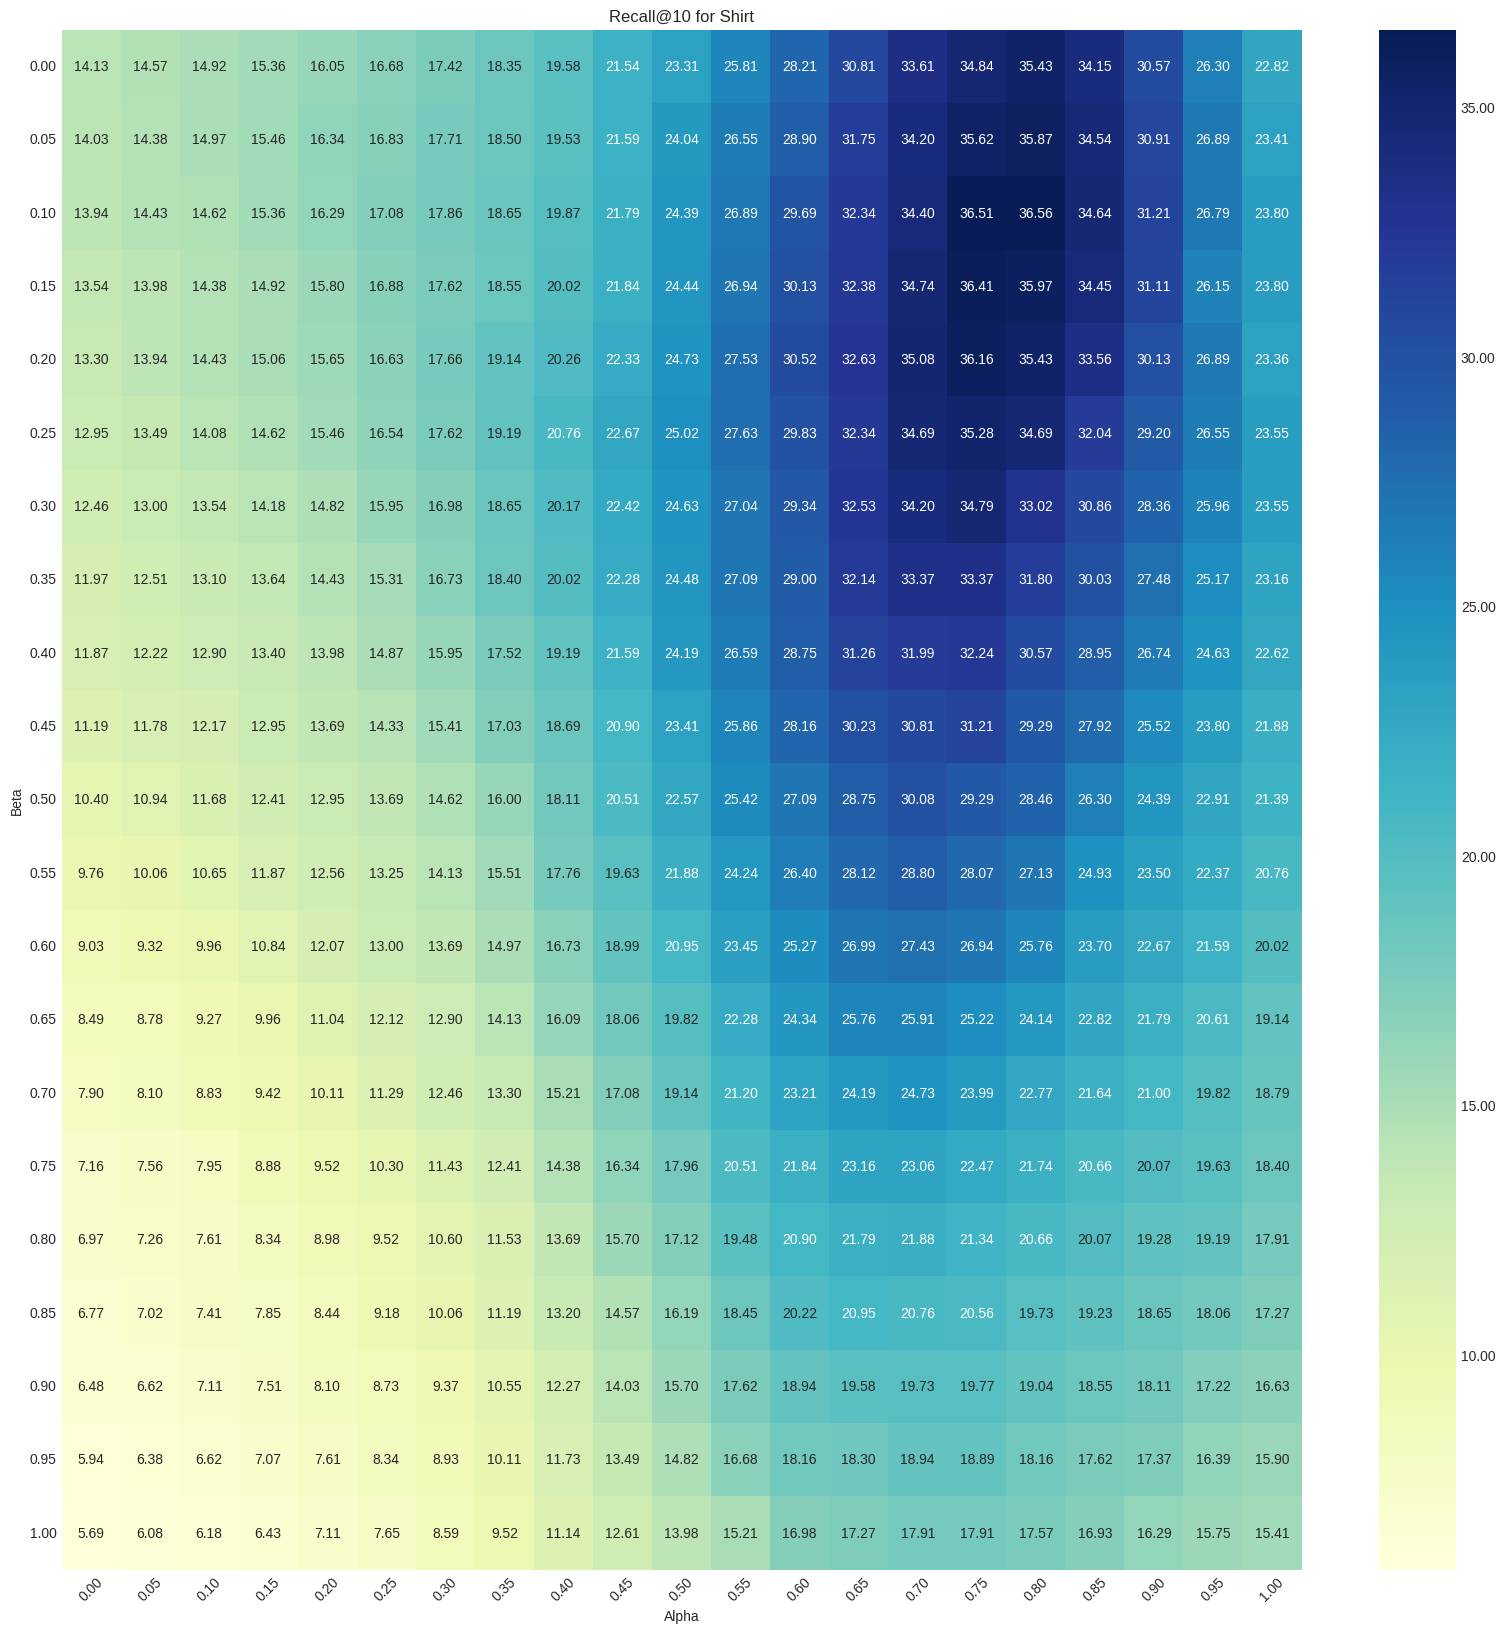

In [22]:
prepare_and_plot_recall_pivot(shirt_recall_at10, "Recall@10 for Shirt")

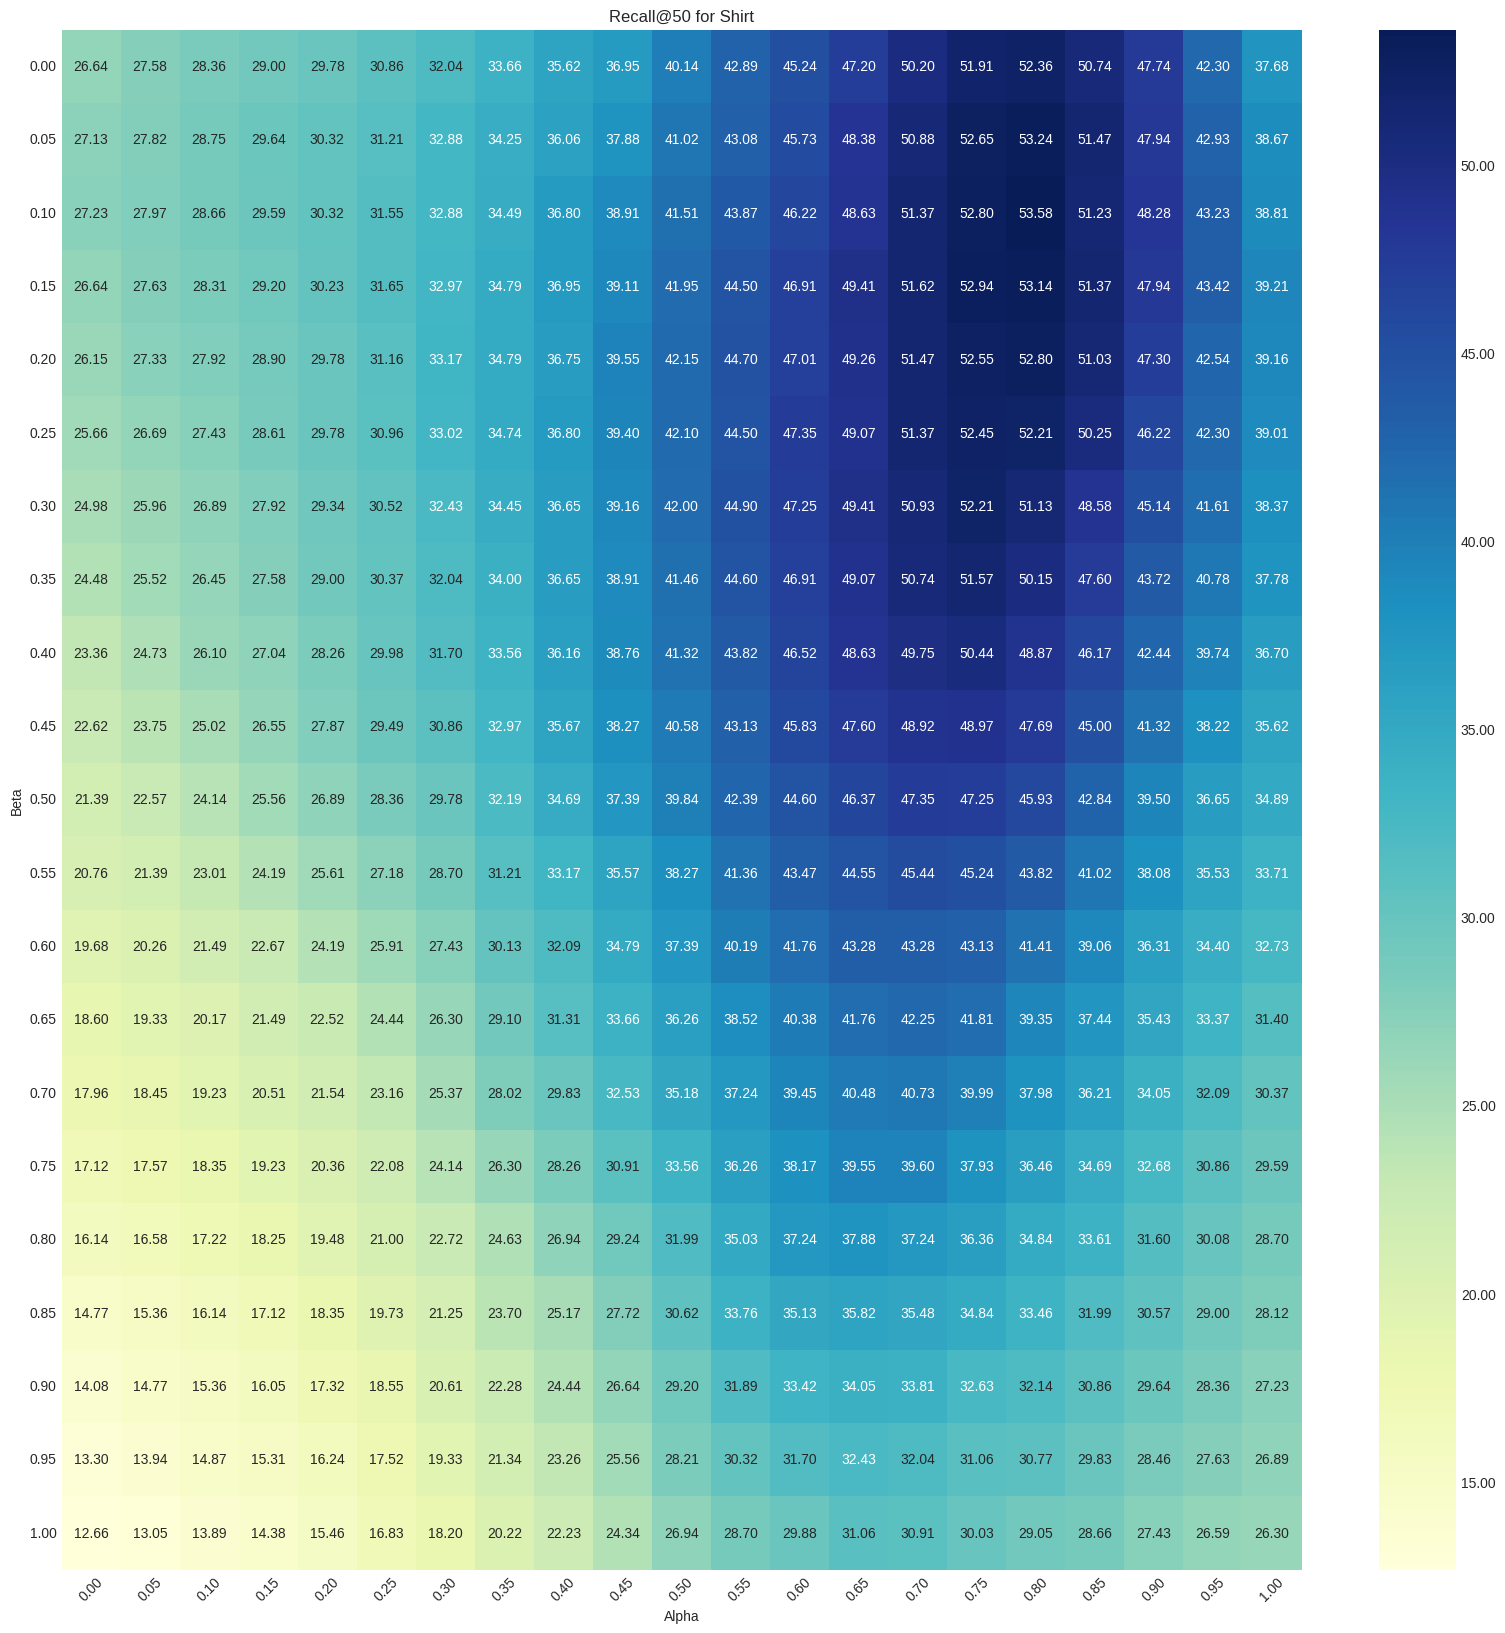

In [23]:
prepare_and_plot_recall_pivot(shirt_recall_at50, "Recall@50 for Shirt")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Dress</div>

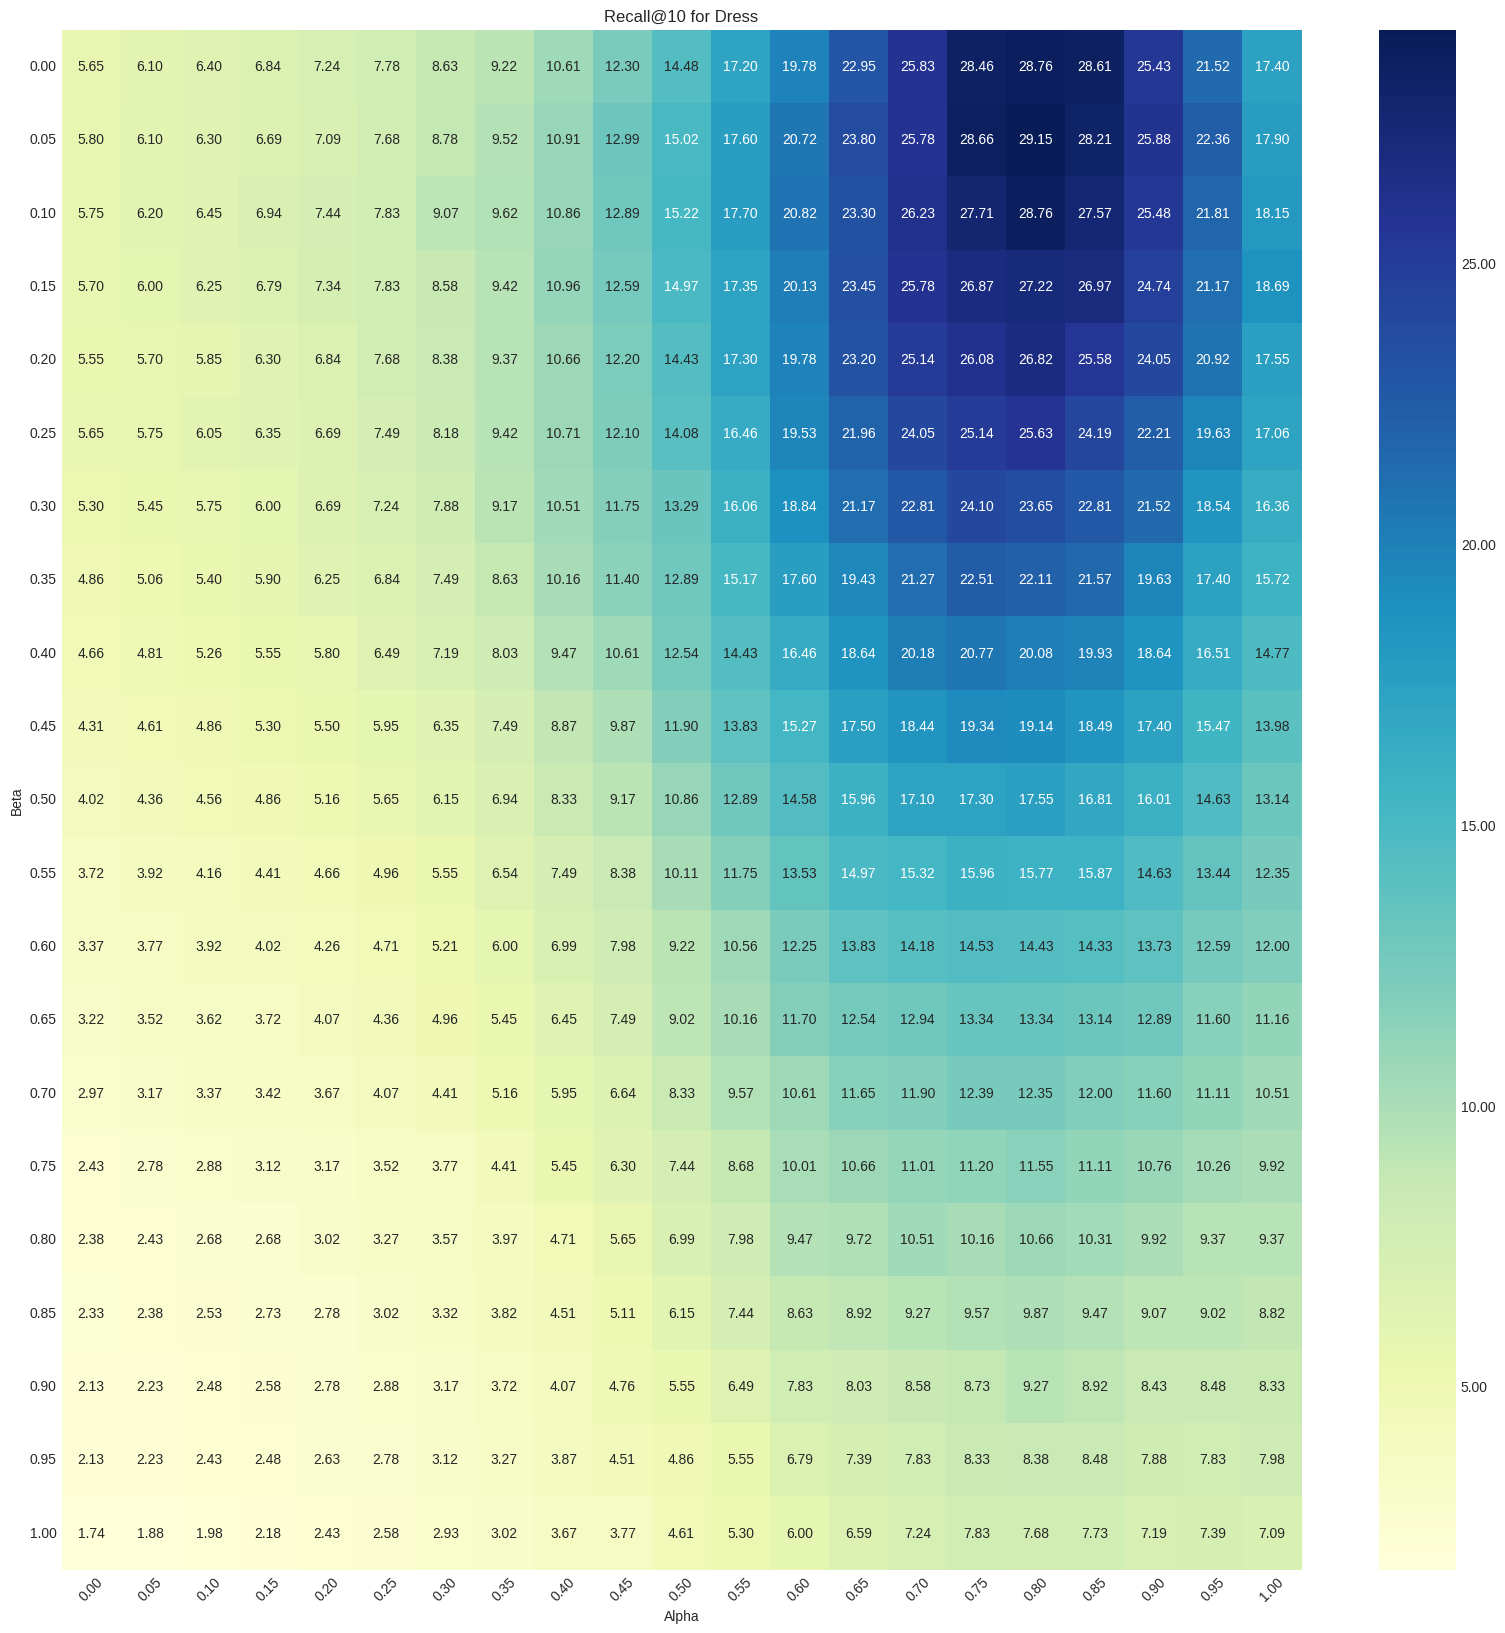

In [24]:
prepare_and_plot_recall_pivot(dress_recall_at10, "Recall@10 for Dress")

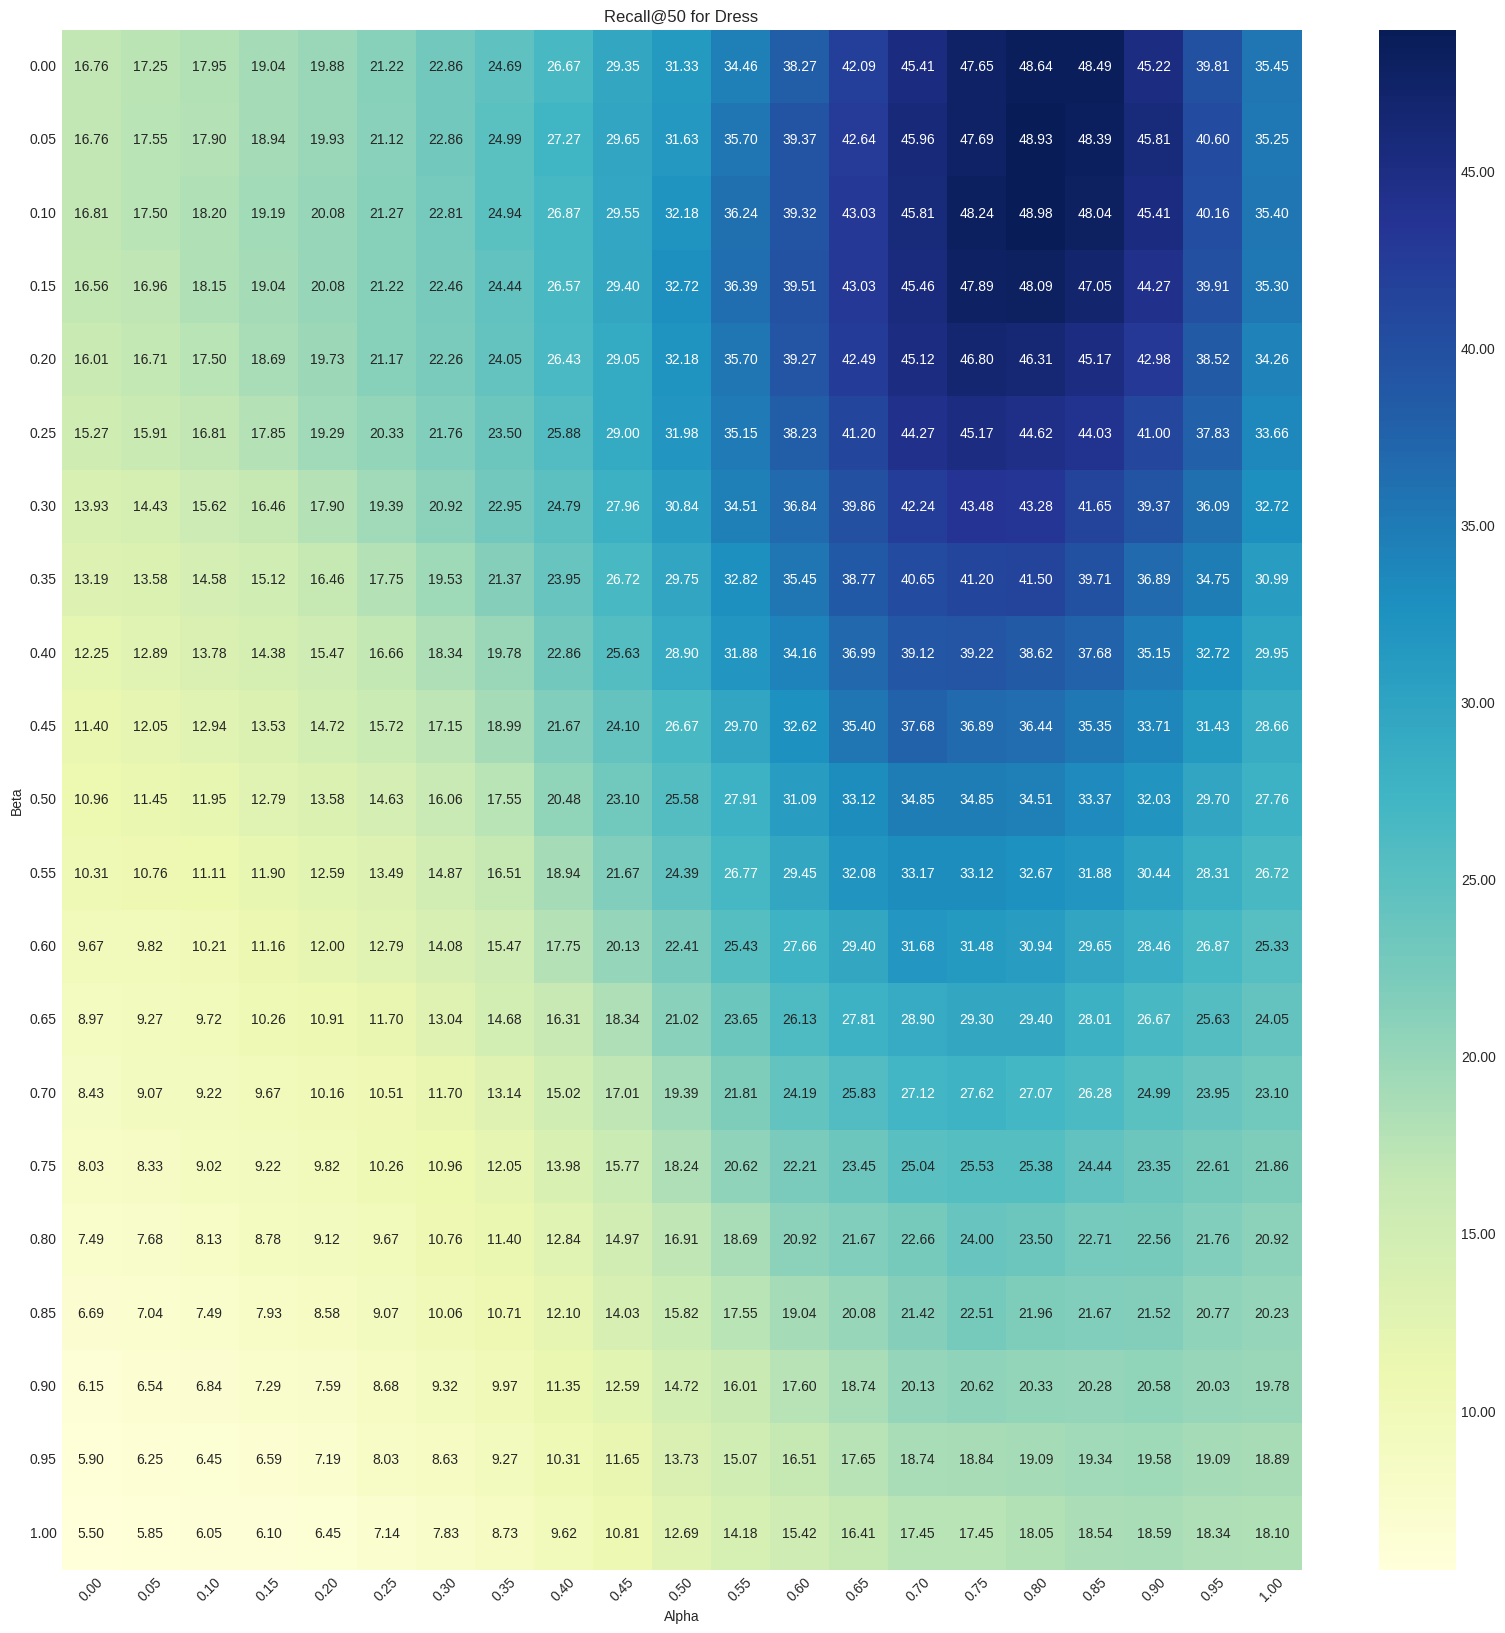

In [25]:
prepare_and_plot_recall_pivot(dress_recall_at50, "Recall@50 for Dress")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for TopTee</div>

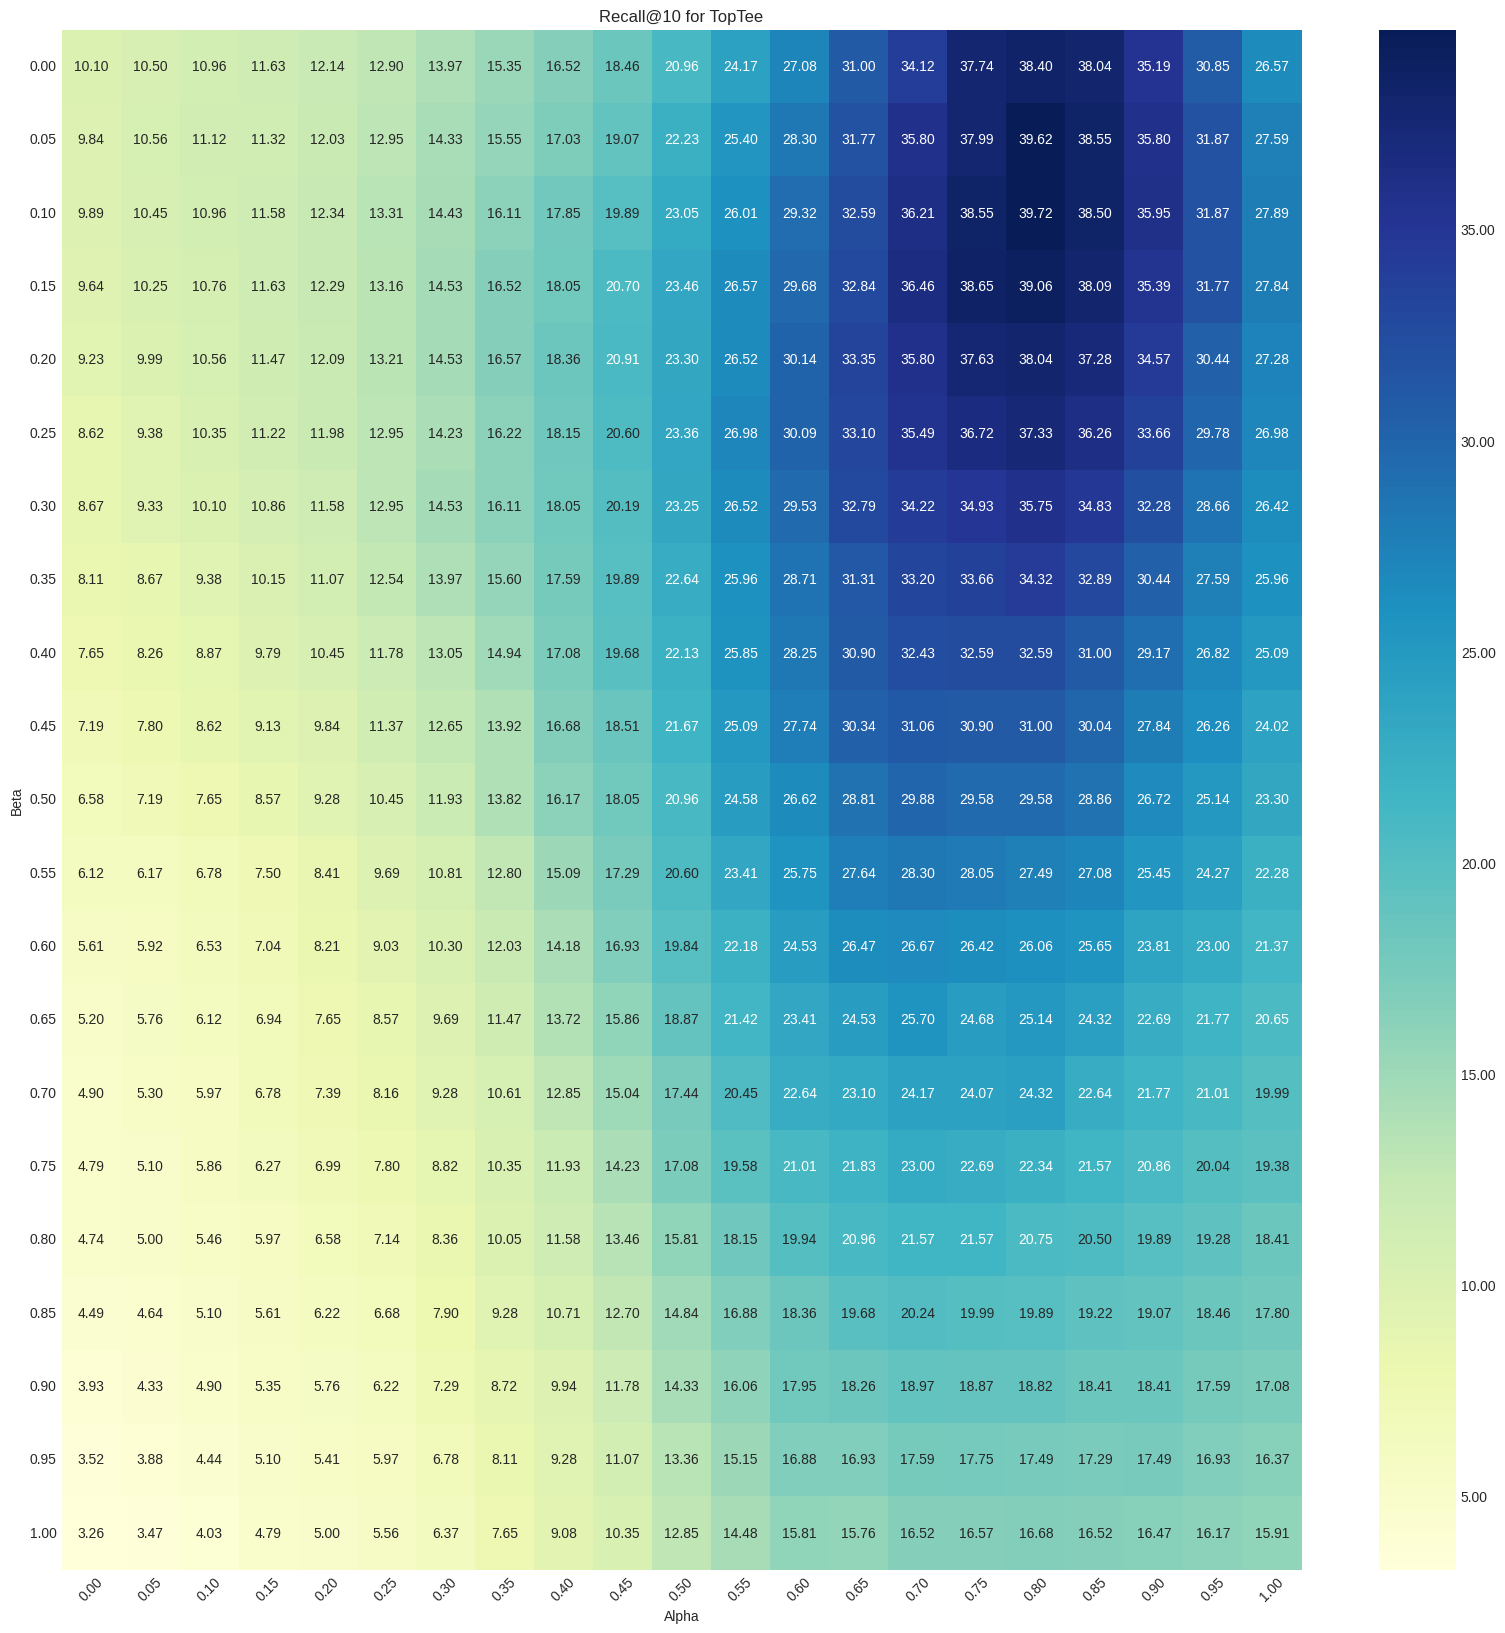

In [26]:
prepare_and_plot_recall_pivot(toptee_recall_at10, "Recall@10 for TopTee")

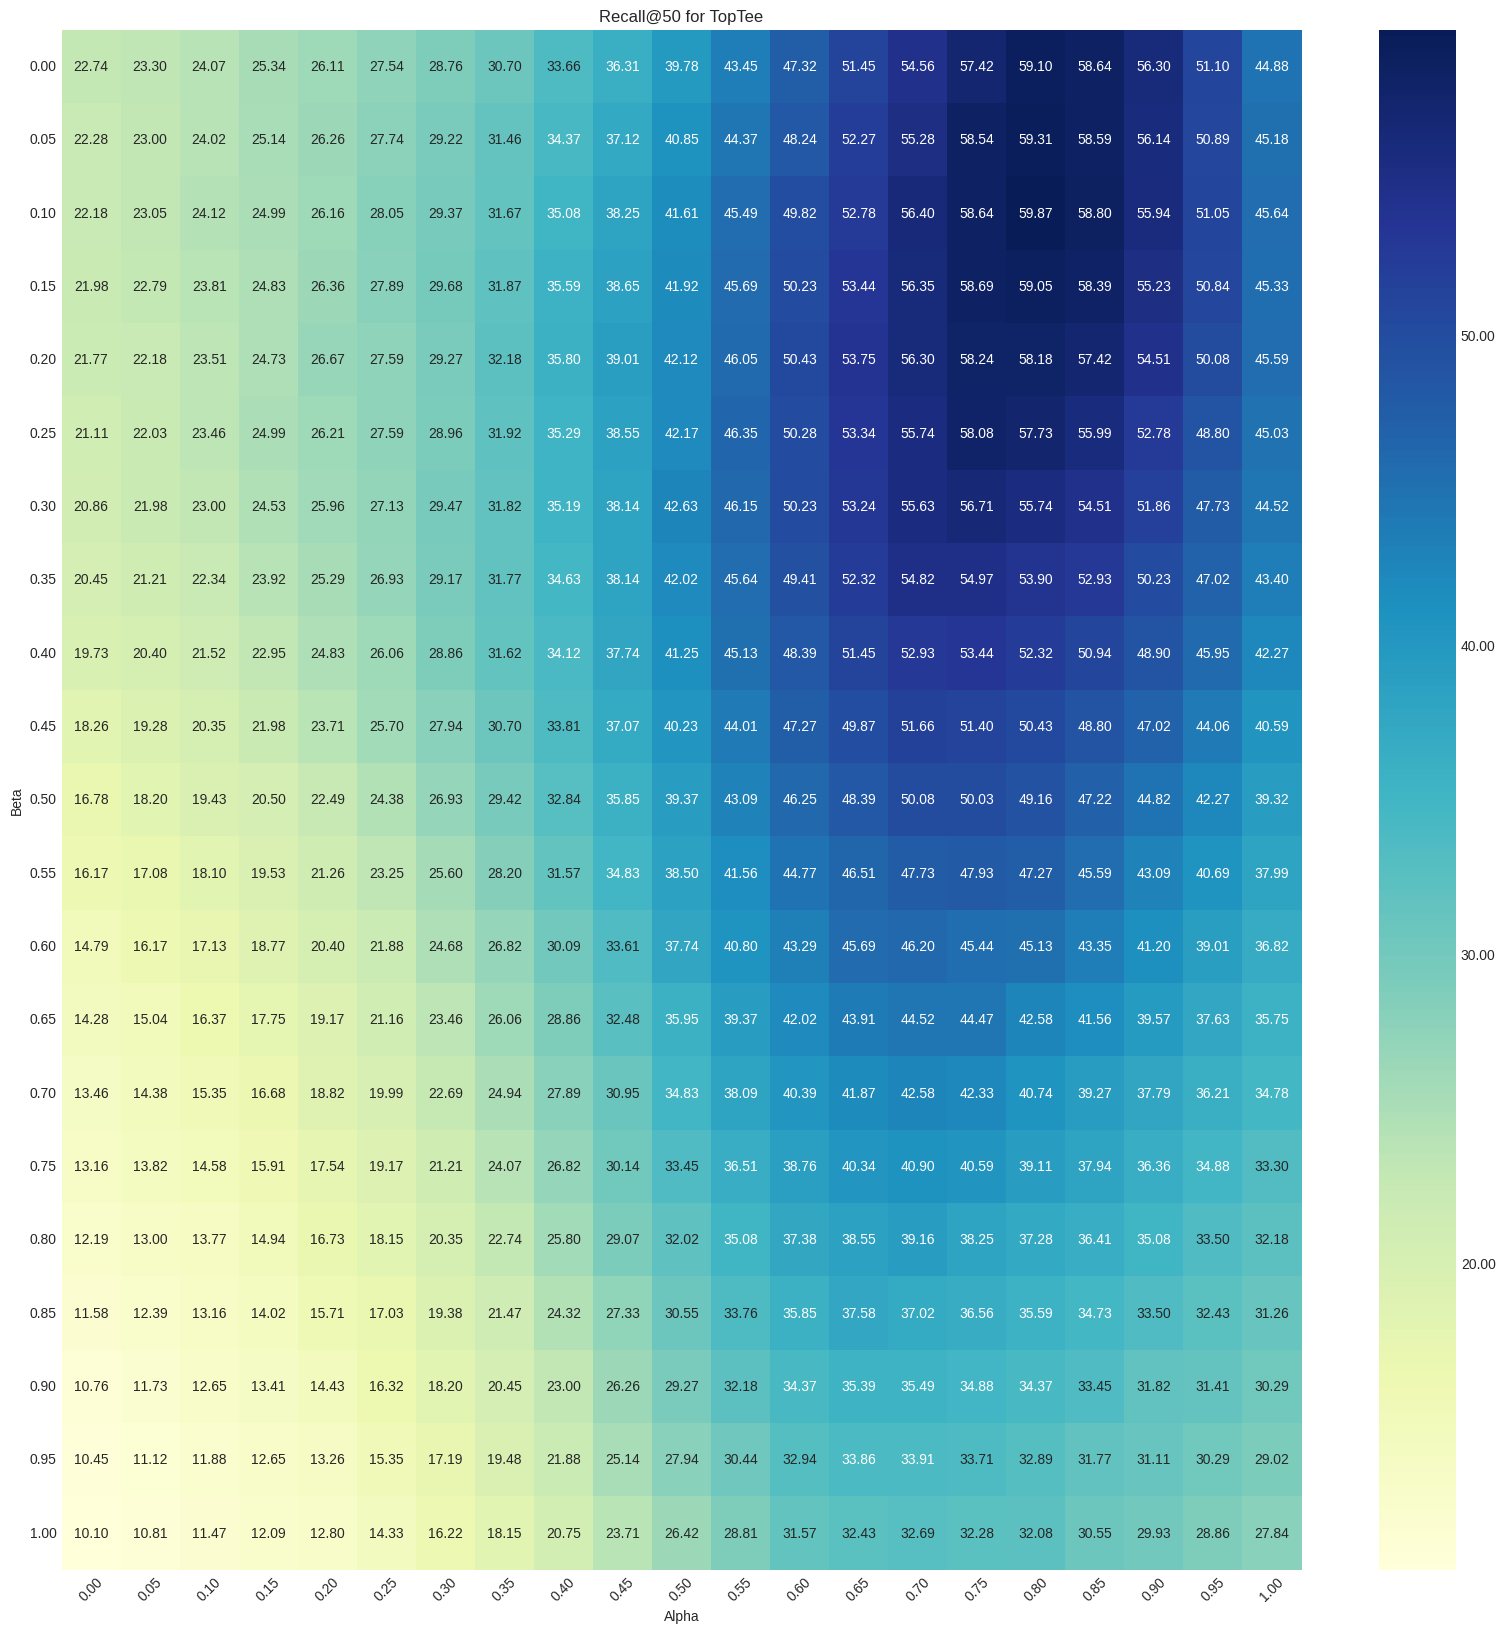

In [27]:
prepare_and_plot_recall_pivot(toptee_recall_at50, "Recall@50 for TopTee")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the average recall at 10 and 50 for all categories</div>

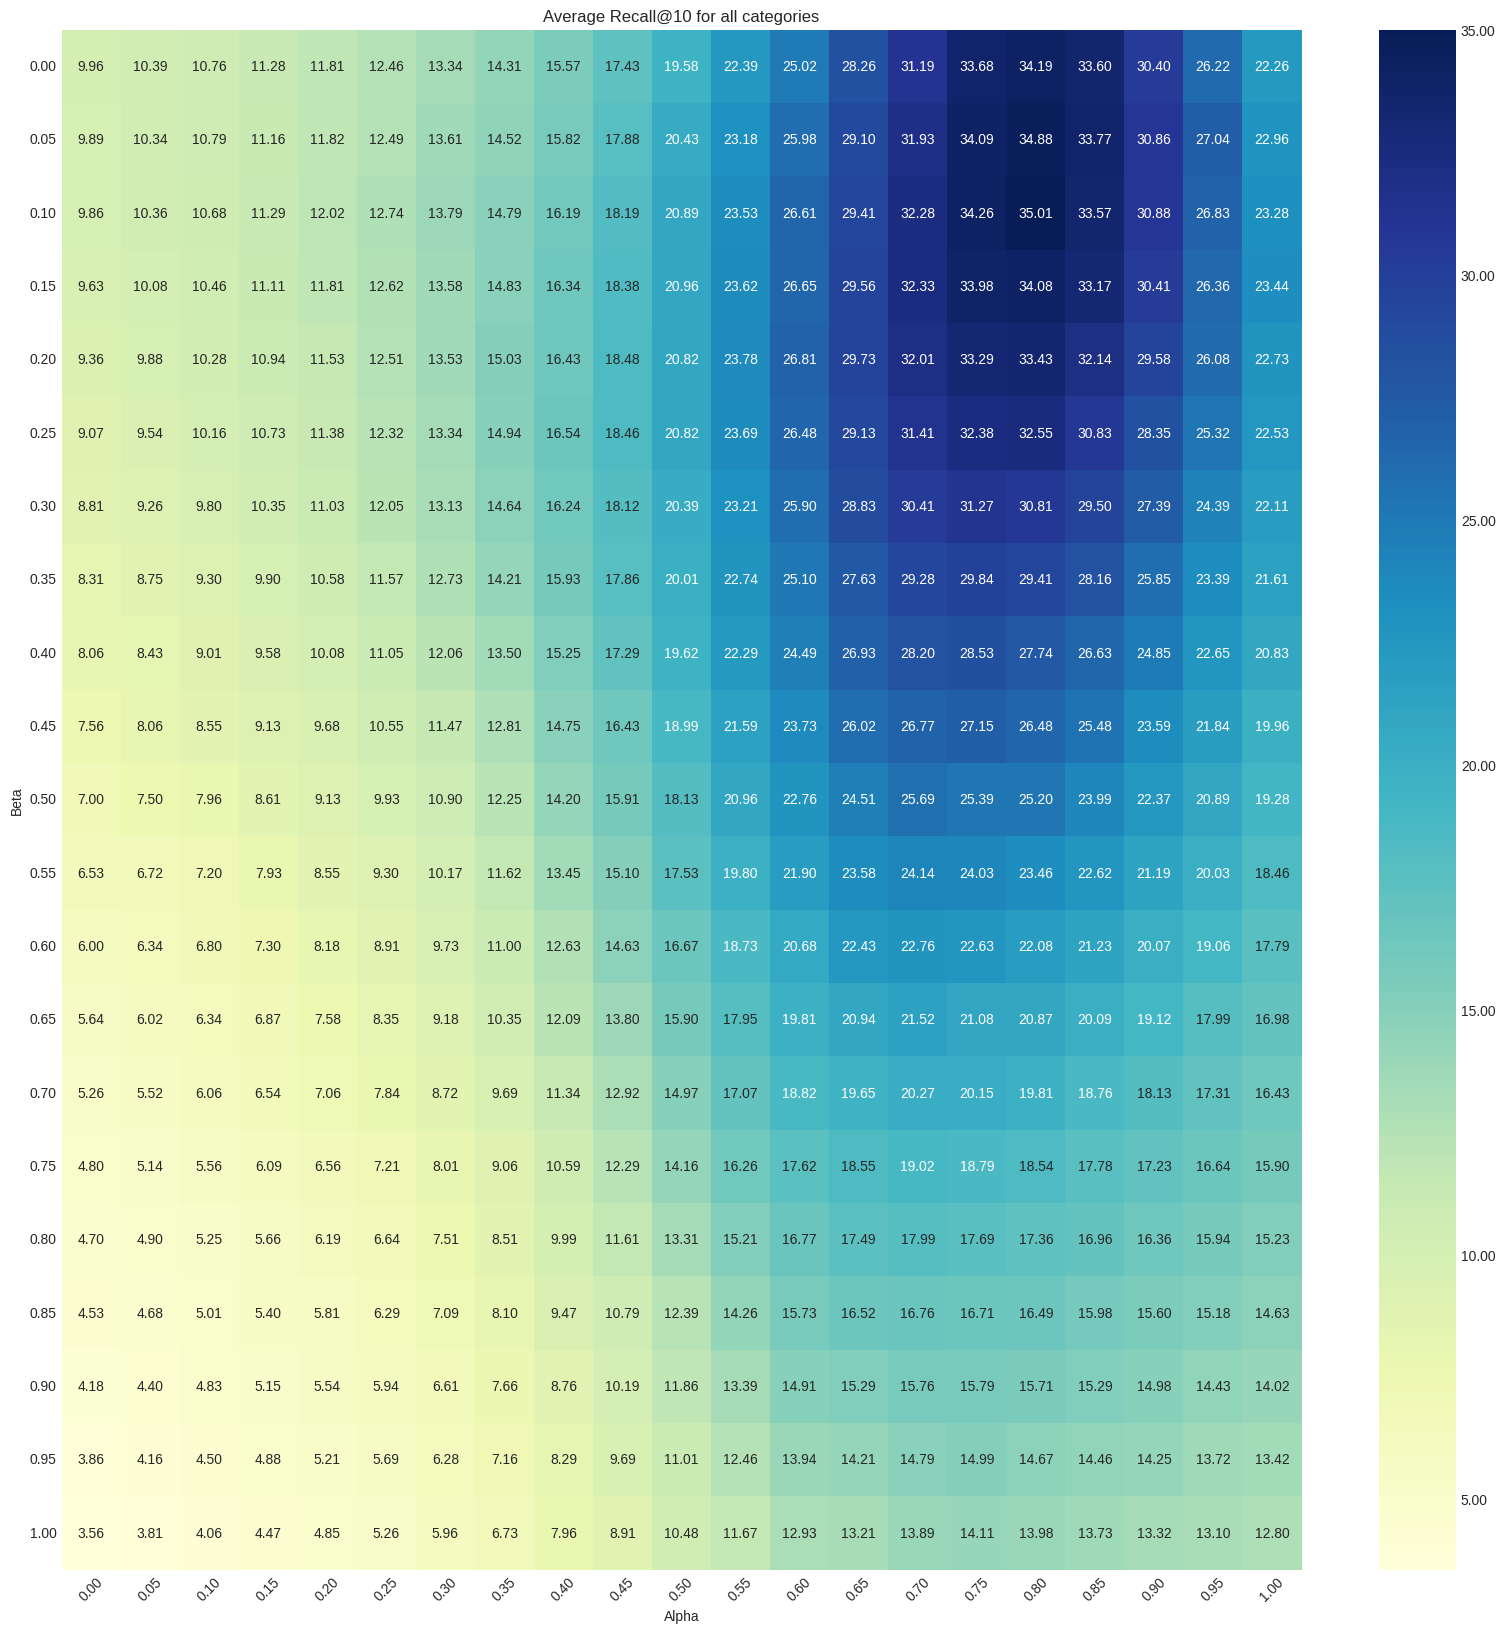

In [28]:
prepare_and_plot_recall_pivot(average_recall_at10, "Average Recall@10 for all categories")

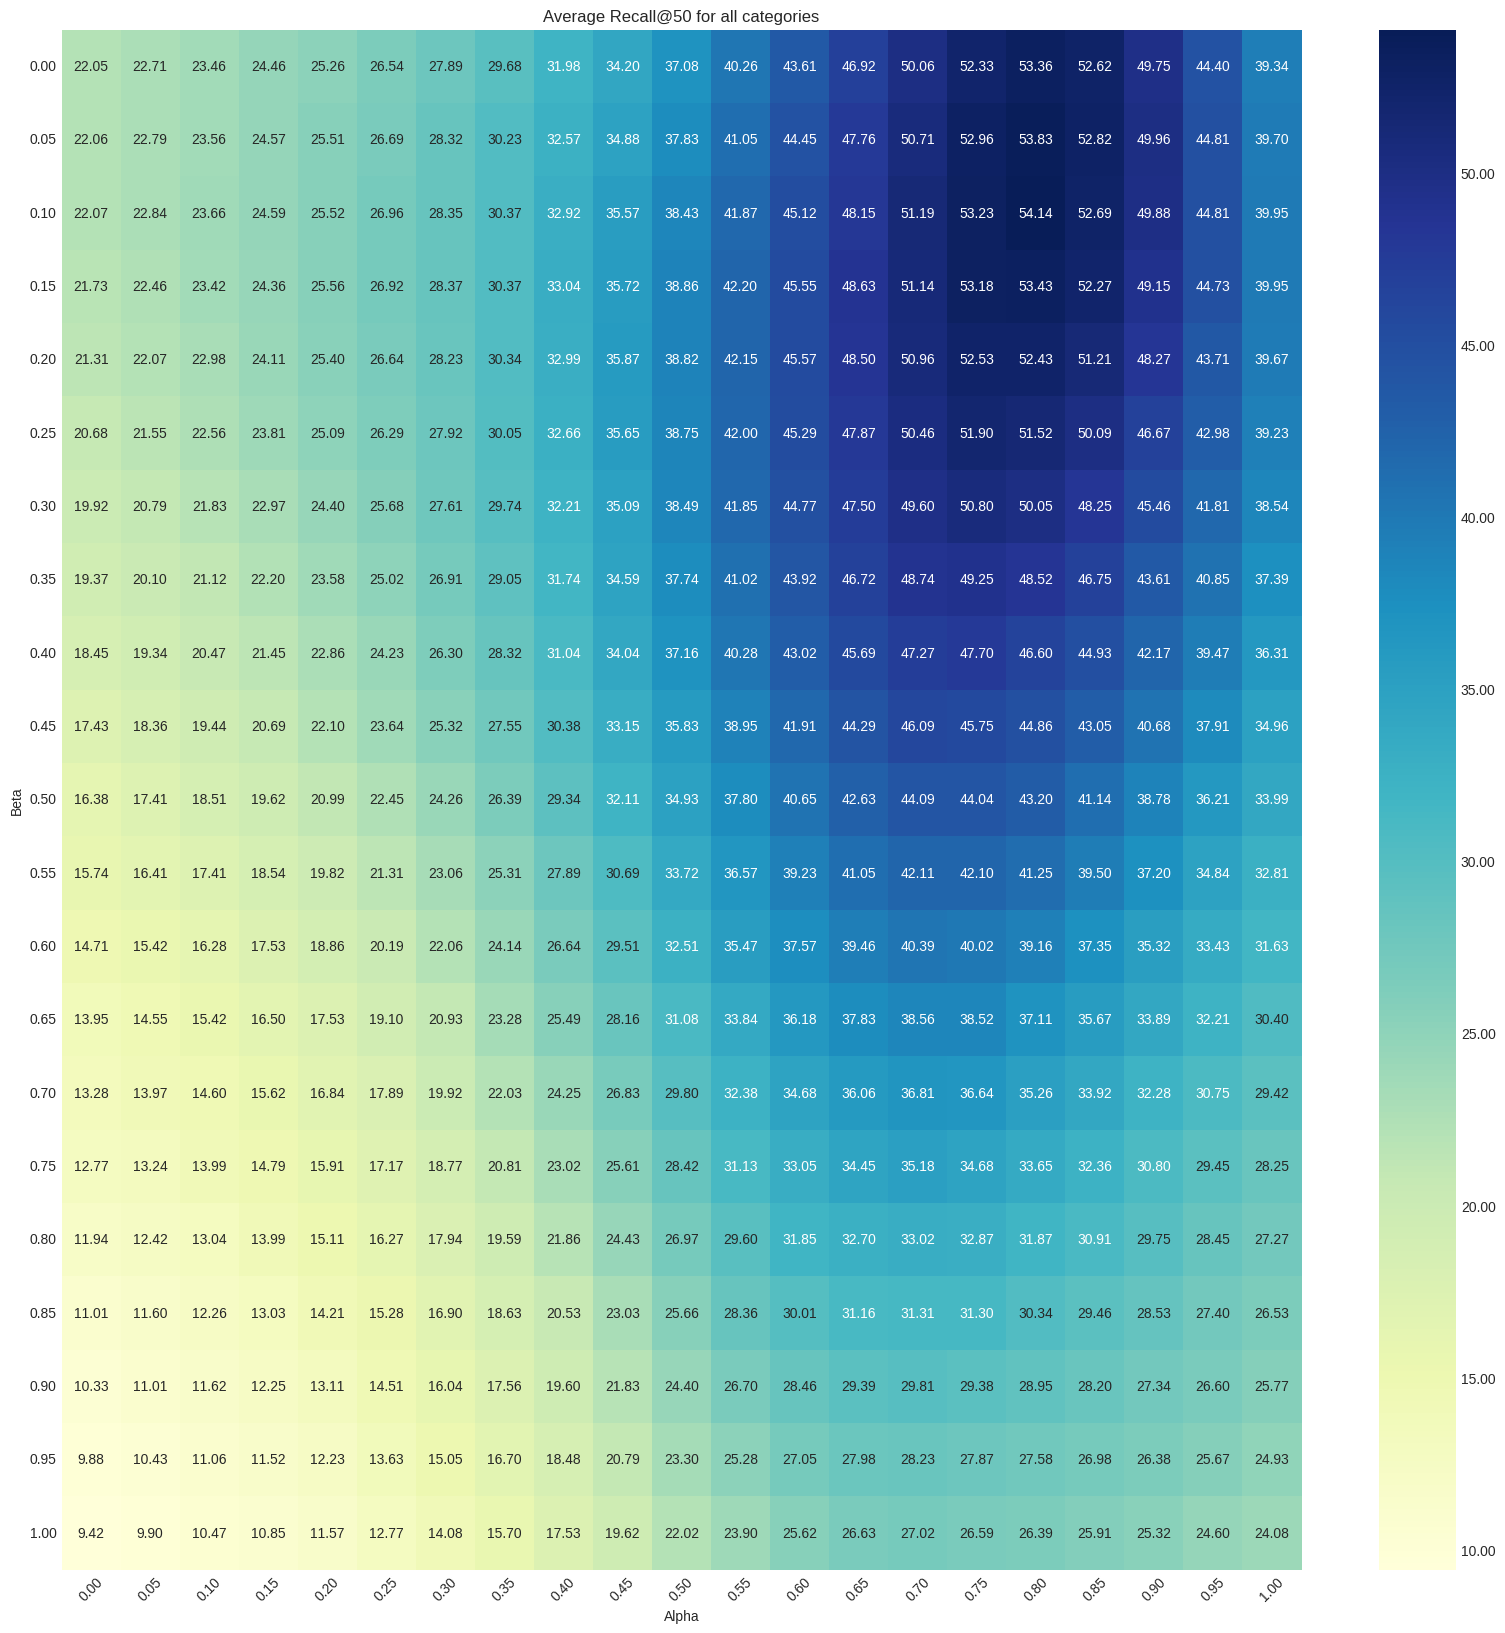

In [29]:
prepare_and_plot_recall_pivot(average_recall_at50, "Average Recall@50 for all categories")

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5: View some sample of the result</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category</div>

In [30]:
sorted_indices_shirt, image_index_names_shirt, target_names_shirt = compute_results_fiq_val_clip(
    'shirt',
    get_combing_function_with_alpha(0.8),
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    beta=0.1,
    cache=cache,
)

Recall at 10: 36.555445194244385
Recall at 50: 53.5819411277771


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category</div>

In [31]:
sorted_indices_dress, image_index_names_dress, target_names_dress = compute_results_fiq_val_clip(
    'dress',
    get_combing_function_with_alpha(0.8),
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    beta=0.1,
    cache=cache,
)

Recall at 10: 28.75557839870453
Recall at 50: 48.98363947868347


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category</div>

In [32]:
sorted_indices_toptee, image_index_names_toptee, target_names_toptee = compute_results_fiq_val_clip(
    'toptee',
    get_combing_function_with_alpha(0.8),
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    beta=0.1,
    cache=cache,
)

Recall at 10: 39.72463011741638
Recall at 50: 59.867411851882935


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Prepare the ground truth data</div>

In [33]:
ground_truth_dress = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.dress.val.json')))
ground_truth_shirt = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.shirt.val.json')))
ground_truth_toptee = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.toptee.val.json')))

DATASET_IMAGE_DIR = '../../../fashionIQ_dataset/images/'

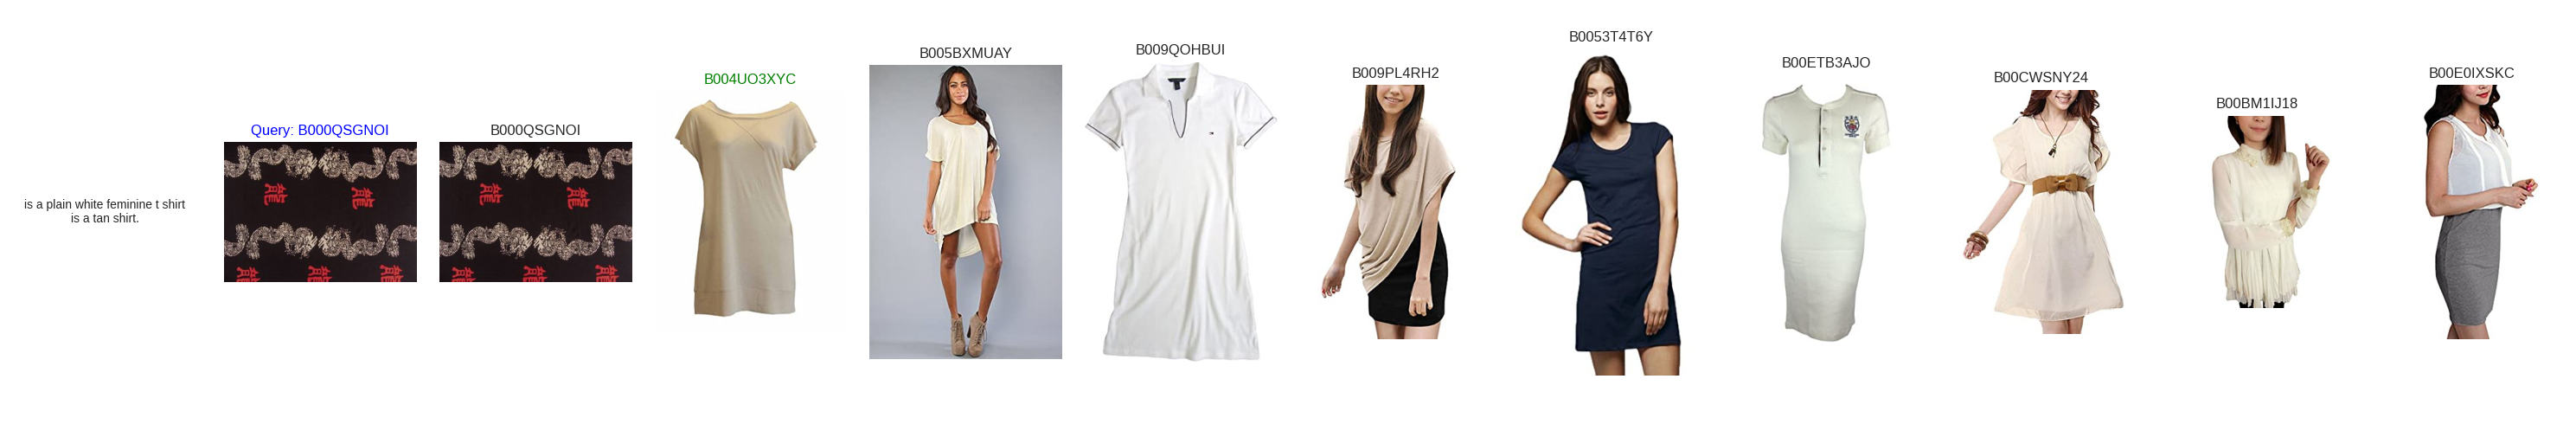

In [34]:
plot_retrieval_results_of_i(
    sorted_indices_dress, 
    image_index_names_dress, 
    target_names_dress, 
    ground_truth_dress, 
    top_k=10, 
    i=3,
    directory=DATASET_IMAGE_DIR,
)

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6: Compare with the original without MMLM captions and identical weights element-wise sum</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category</div>

In [35]:
sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin = compute_results_fiq_val_clip(
    'shirt',
    combining_function_original,
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 23.307164013385773
Recall at 50: 40.13738930225372


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category</div>

In [36]:
sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin = compute_results_fiq_val_clip(
    'dress',
    combining_function_original,
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 14.476945996284485
Recall at 50: 31.333664059638977


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category</div>

In [37]:
sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin = compute_results_fiq_val_clip(
    'toptee',
    combining_function_original,
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 20.95869481563568
Recall at 50: 39.77562487125397


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Shirt category</div>

In [38]:
become_better = found_better_than_original(
    sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin,
    sorted_indices_shirt, image_index_names_shirt, target_names_shirt,
    top_k=10
)

len(become_better), become_better[:10]

(356, [0, 6, 13, 16, 19, 21, 26, 32, 37, 45])

In [39]:
become_worse = found_better_than_original(
    sorted_indices_shirt, image_index_names_shirt, target_names_shirt,
    sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(79, [9, 12, 35, 54, 75, 84, 123, 126, 138, 184])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Dress category</div>

In [40]:
become_better = found_better_than_original(
    sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin,
    sorted_indices_dress, image_index_names_dress, target_names_dress,
    top_k=10
)

len(become_better), become_better[:10]

(353, [0, 1, 12, 16, 19, 26, 40, 45, 51, 52])

In [41]:
become_worse = found_better_than_original(
    sorted_indices_dress, image_index_names_dress, target_names_dress,
    sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(58, [11, 23, 41, 62, 125, 134, 169, 218, 298, 352])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the TopTee category</div>

In [42]:
become_better = found_better_than_original(
    sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin,
    sorted_indices_toptee, image_index_names_toptee, target_names_toptee,
    top_k=10
)

len(become_better), become_better[:10]

(423, [6, 7, 9, 10, 15, 20, 21, 26, 28, 30])

In [43]:
become_worse = found_better_than_original(
    sorted_indices_toptee, image_index_names_toptee, target_names_toptee,
    sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(53, [31, 96, 112, 142, 216, 230, 243, 292, 484, 486])

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 7: Visualize the comparison</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Shirt category</div>

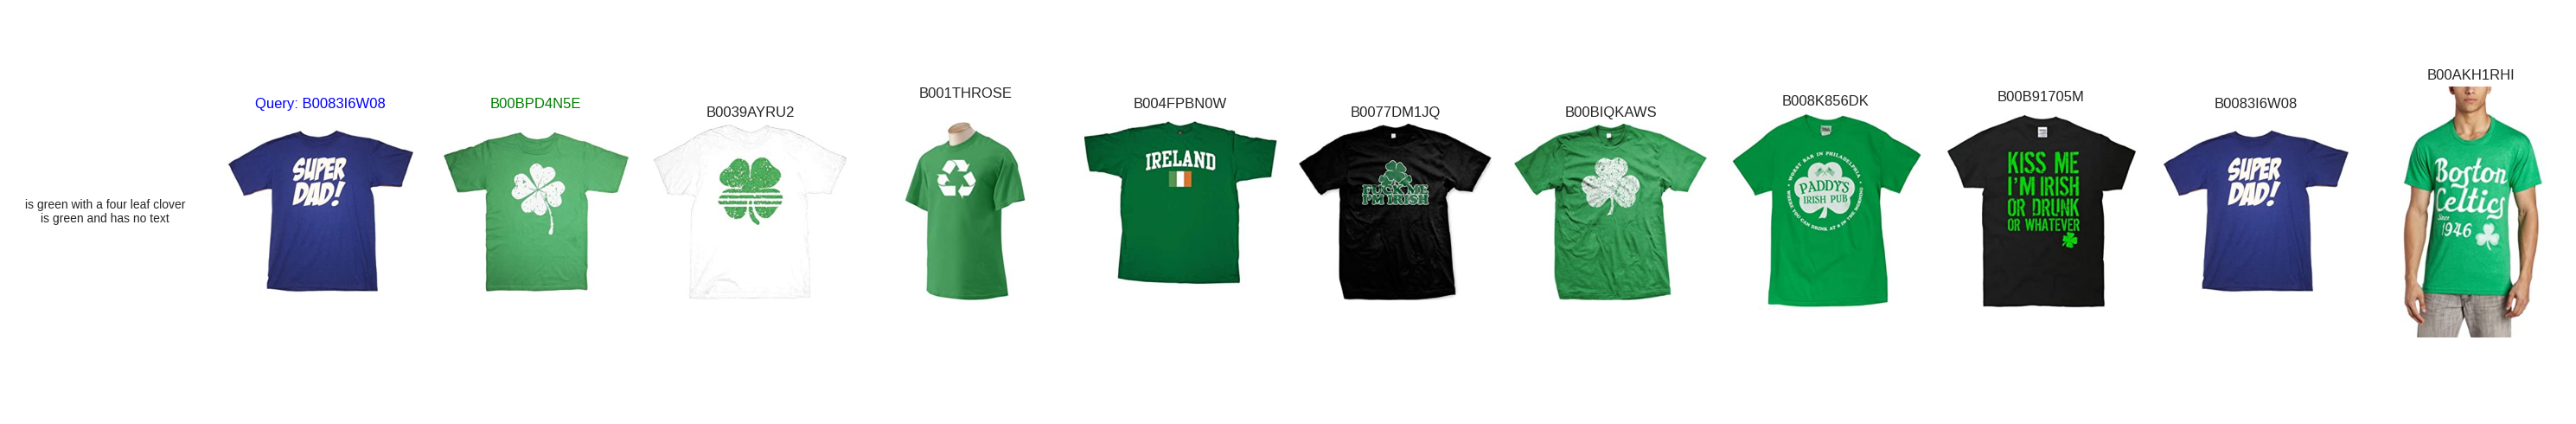

In [44]:
plot_retrieval_results_of_i(sorted_indices_shirt, image_index_names_shirt, target_names_shirt, ground_truth_shirt, top_k=10, i=1, directory=DATASET_IMAGE_DIR)

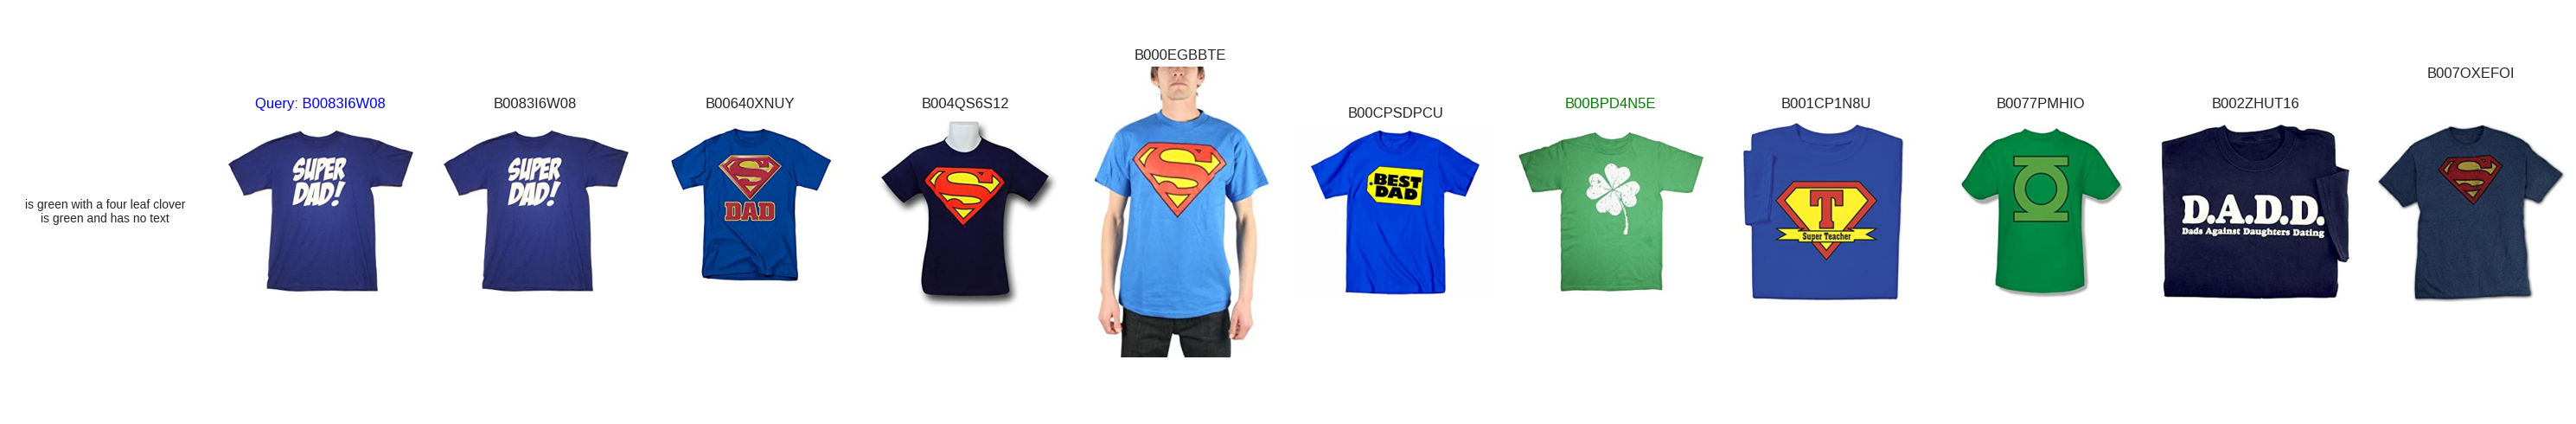

In [45]:
plot_retrieval_results_of_i(sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin, ground_truth_shirt, top_k=10, i=1, directory=DATASET_IMAGE_DIR)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Dress category</div>

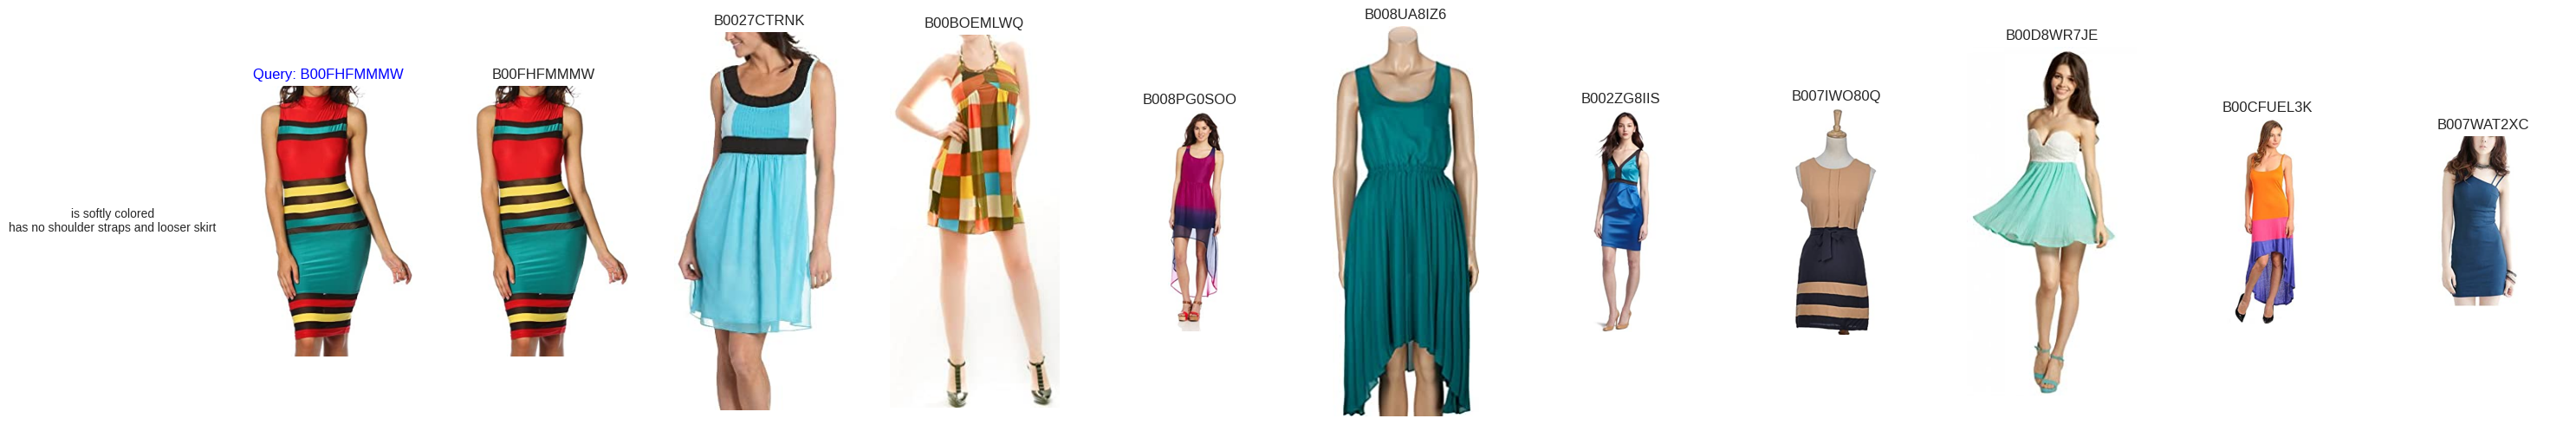

In [46]:
plot_retrieval_results_of_i(sorted_indices_dress, image_index_names_dress, target_names_dress, ground_truth_dress, top_k=10, i=11, directory=DATASET_IMAGE_DIR)

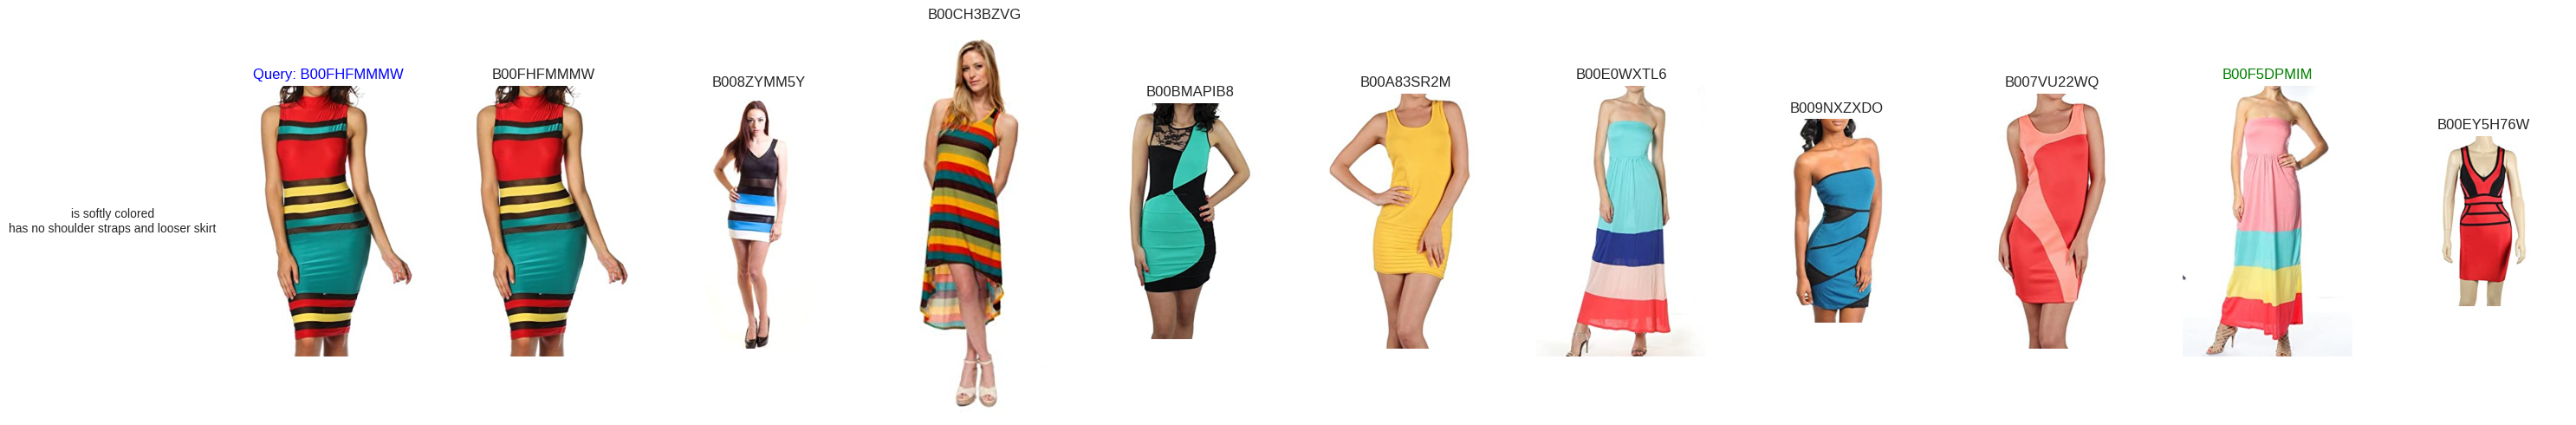

In [47]:
plot_retrieval_results_of_i(sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin, ground_truth_dress, top_k=10, i=11, directory=DATASET_IMAGE_DIR)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the TopTee category</div>

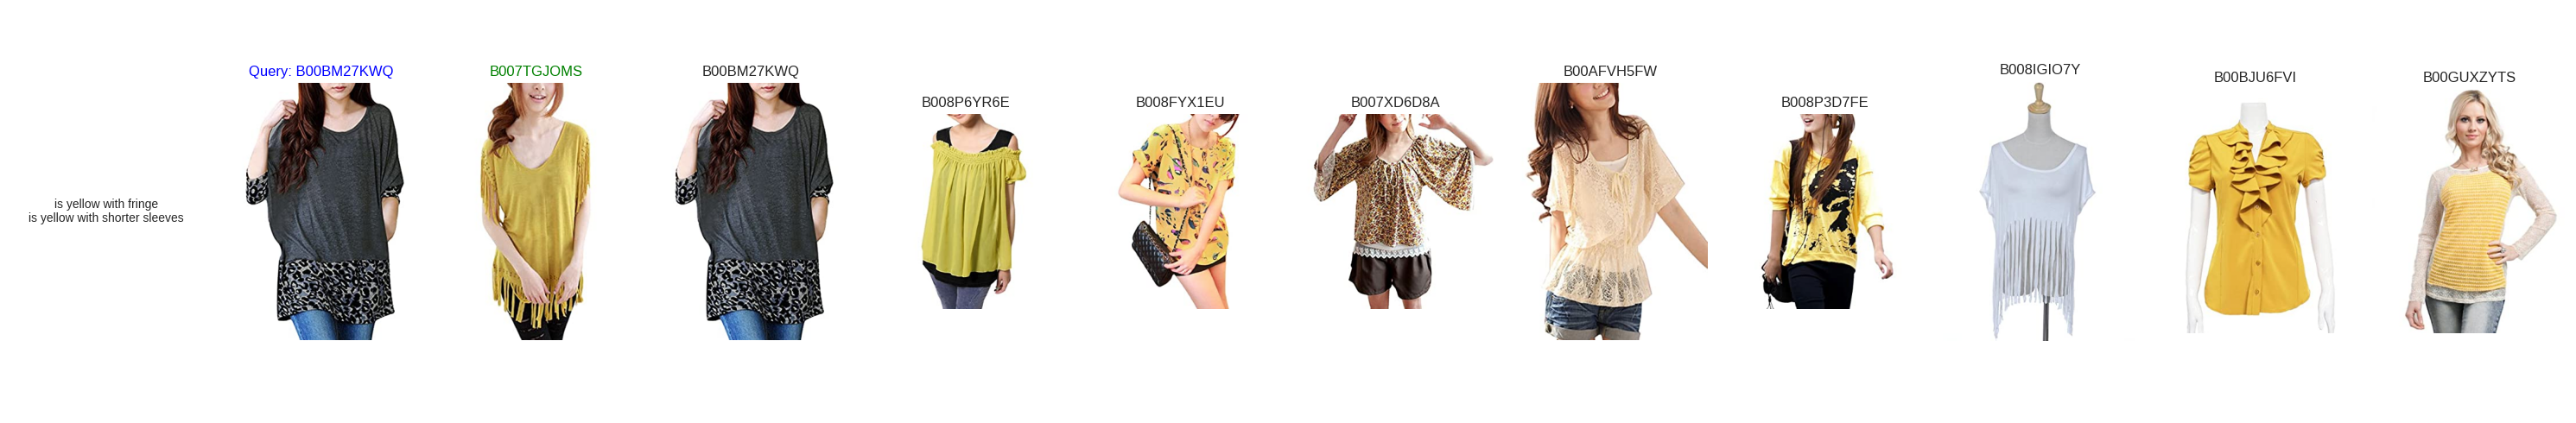

In [48]:
plot_retrieval_results_of_i(sorted_indices_toptee, image_index_names_toptee, target_names_toptee, ground_truth_toptee, top_k=10, i=2, directory=DATASET_IMAGE_DIR)

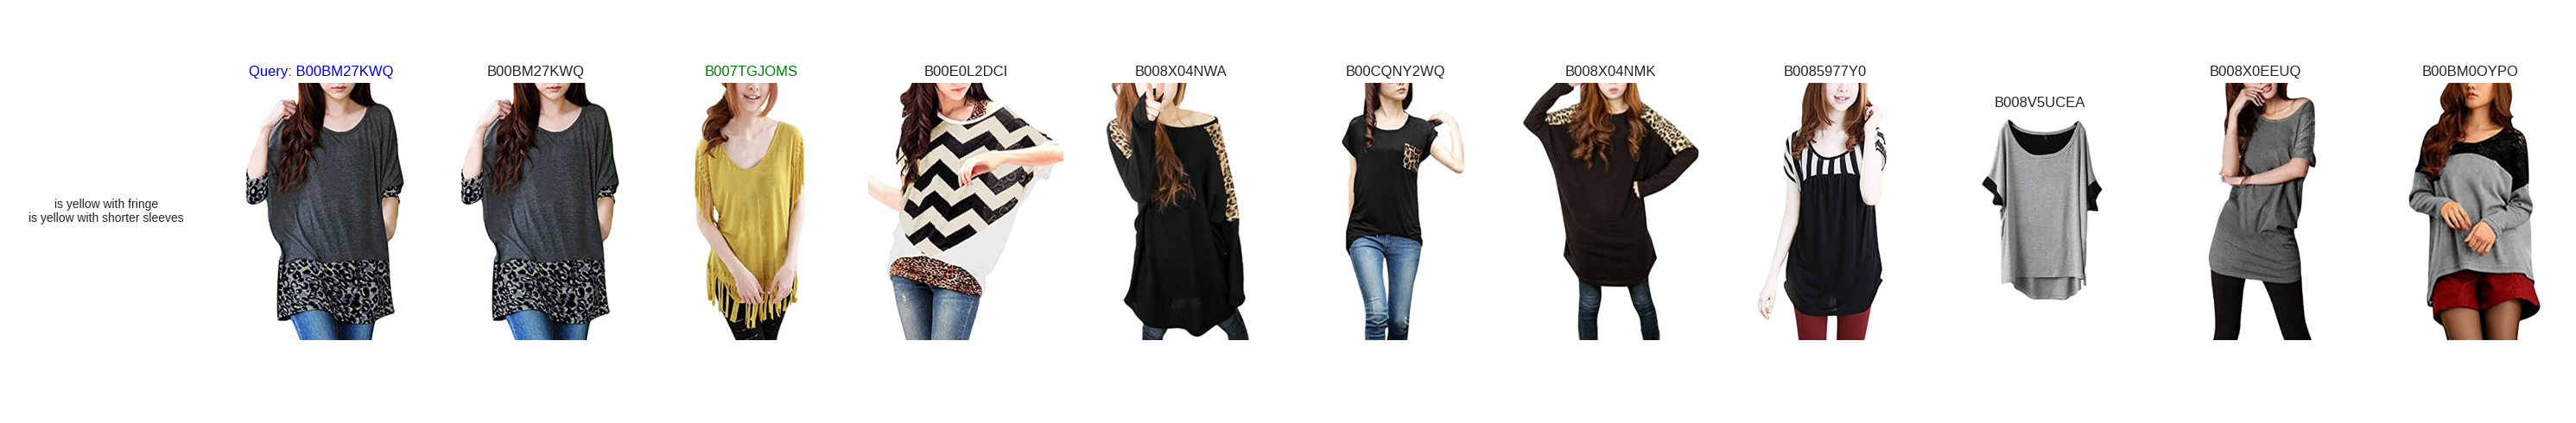

In [49]:
plot_retrieval_results_of_i(sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin, ground_truth_toptee, top_k=10, i=2, directory=DATASET_IMAGE_DIR)